In [43]:
# Importing essential libraries
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import calendar
from sklearn.linear_model import LinearRegression
import json
import seaborn as sns
from math import floor
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Setting a random seed for consistency in results
np.random.seed(2)

# Disabling chained assignment warnings in pandas
pd.options.mode.chained_assignment = None

# Beyond Originals: A Deep Dive into Sequel Success

In this project, our focus is on movies and their sequels, as well as movies without sequels. The initial step involves data preprocessing to facilitate subsequent analysis.

## Data collection

To actually carry out our project idea, we needed to obtain one extra information, which is not given in our initial dataset: _does a movie have a sequel?_

We extracted the missing information regarding movie sequels by web scraping from Wikipedia and Wikidata. Indeed, Wikidata has a specific section dedicated to this, as can be seen in the image here-under. 

<div>
<img src="./sequel_scraper/wikidata_sequel_info.png" width="700"/>
</div>



The code used for this is in the file "wiki_scraper.py" which can be found under ./sequel_scraper. 

Here's a recap of the what the code does:

Data Loading:
The code starts by importing necessary libraries, such as pandas for data manipulation, requests for making HTTP requests, and BeautifulSoup for web scraping.
The movie metadata is loaded from a TSV file into a Pandas DataFrame. 

Two functions are defined for web scraping:
extract_ID: Extracts the Wikidata ID from a given string.
scrape_wikidata_id: Scrapes the Wikidata ID for a given movie from its Wikipedia page.
scrape_sequels: Scrapes the prequel and sequel IDs for a given movie from its Wikidata page.

Scraping Loop:
A new Pandas DataFrame named online_scraping is created with columns 'WikipediaID', 'WikidataID', 'PrequelID', and 'SequelID' to store the scraping results.
A loop iterates over the dataframe, calling the scrape_wikidata_id and scrape_sequels functions to extract Wikidata and sequel information for each movie.
The results are stored in the online_scraping DataFrame.

Output:
The scraping results are saved to a CSV file named 'sequels.csv'. The CSV file includes columns for WikipediaID, WikidataID, PrequelID, and SequelID.


## Some initial dataframes

For reference, here are the naming conventions used:
- An _original_ movie is a movie that has a sequel

The file *sequels.csv* contains 4 columns : 
- WikipediaID : ID from wikipedia
- WikidataID : ID from wikidata
- PrequelID : ID of the prequel from wikidata (nan when there is no prequel) 
- SequelID : ID of the sequel from wikidata (nan when there is no sequel) 

In [44]:
# Reading the dataset from a CSV file and filtering to keep only movies with a sequel
from_csv = pd.read_csv("sequels.csv")
originals_sequels = from_csv[['WikipediaID', 'WikidataID', 'SequelID']].dropna(subset=['SequelID'])

In [45]:
# Reading the CMU movie dataset
cmu_movies = pd.read_csv("movie_summaries/movie.metadata.tsv", sep="\t", 
                         names=['WikipediaID', 'FreebaseID', 'MovieName', 'ReleaseDate', 
                                'BoxOffice', 'Runtime', 'Languages', 'Countries', 'Genres'])

 Before moving on to the next phase, we encountered some errors while exploring the data. Since these errors are not frequent, we have opted to address them manually and make the necessary updates.

### Error corrections

**Zero Tolerance** has a runtime of 1079281 minutes which is false when looking up on the [wikipedia page](https://en.wikipedia.org/wiki/Zero_Tolerance_(1994_film)), the true value is 94 minutes. 

**Hunting Season** has 1010 as the released year, which is also a mistake when looking at the [wikipedia page](https://en.wikipedia.org/wiki/Hunting_Season_(2010_film)), the true year of released is 2010. 

In [46]:
# Fixing runtime for Zero Tolerance
cmu_movies.at[12804,'Runtime'] = 94.0 

# Fixing date for Hunting Season
cmu_movies.at[62836,'ReleaseDate'] = '2010-12-02'

In [47]:
# Dataframe with only movies that have a sequel
df_has_sequels = cmu_movies[cmu_movies['WikipediaID'].isin(originals_sequels['WikipediaID'])] 

# Dataframe with only movies that don't have a sequel
df_no_sequels = cmu_movies[~cmu_movies['WikipediaID'].isin(originals_sequels['WikipediaID'])] 

In [48]:
# Calculating the percentage of films in the CMU dataset that have sequels
percentage_with_sequels = len(df_has_sequels) / len(cmu_movies)
print(f'Percentage of films with a sequel: {percentage_with_sequels:.2f}')

Percentage of films with a sequel: 0.05


So, only about 5% of movies have a sequel, which isn't much in our dataset. Our objective is to comprehend the distinctions among this subset of films, those without a sequel, and compare them against the overall dataset statistics.



## Part 1: Comparing movies with sequels and movies with no sequels

We will begin by doing some initial comparaison on: 
* Earnings
* Duration
* Month of release
* Year of release
* Country of origin
* Film genre
* Characters
    * Age
    * Gender

### Earnings

Our initial approach involves creating a plot to compare the revenues of movies with sequels to those without sequels. This graphical representation will serve as an initial exploration into the potential differences in revenue between these two categories.

In [49]:
# Filtering out entries without box office data from the dataset of films with sequels
with_sequels_earnings = df_has_sequels.dropna(subset=['BoxOffice'])

# Filtering out entries without box office data from the dataset of films without sequels
no_sequels_earnings = df_no_sequels.dropna(subset=['BoxOffice'])

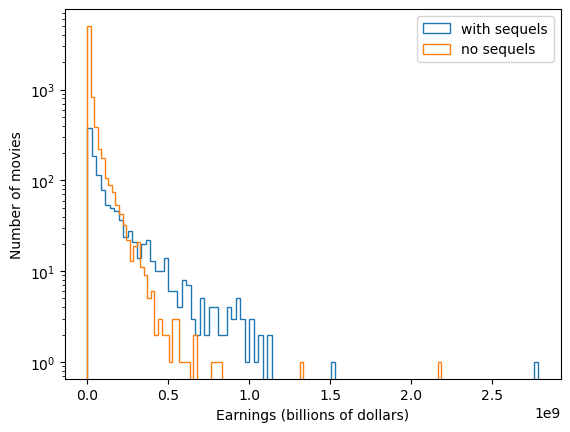

In [50]:
# Plotting histograms to compare the box office earnings of movies with and without sequels
n_bins = 100  # Setting the number of bins for the histogram

# Histogram for movies with sequels
plt.hist(with_sequels_earnings['BoxOffice'], bins=n_bins, log=True, histtype="step", label='with sequels')

# Histogram for movies without sequels
plt.hist(no_sequels_earnings['BoxOffice'], bins=n_bins, log=True, histtype="step", label='no sequels')

# Setting labels and legend for the plot
plt.xlabel('Earnings (billions of dollars)')
plt.ylabel('Number of movies')
plt.legend(loc='best')

# Displaying the plot
plt.show()

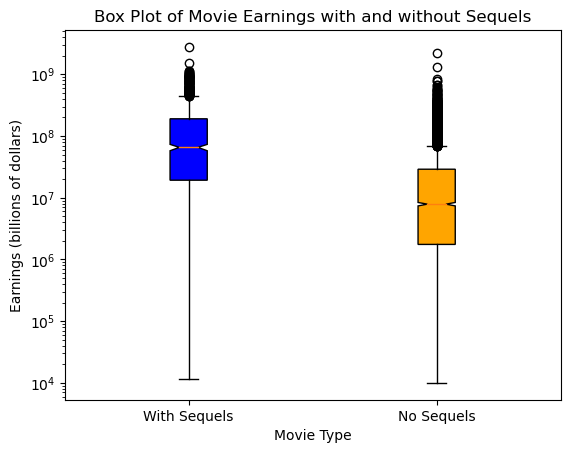

In [51]:
# Creating a box plot to compare the earnings of movies with and without sequels

# Combining earnings data into a list for creating the box plot
earnings_data = [with_sequels_earnings['BoxOffice'], no_sequels_earnings['BoxOffice']]

# Setting the y-axis to a logarithmic scale to handle wide range of earnings
plt.yscale('log')

# Adding labels and title to the plot
plt.xlabel('Movie Type')
plt.ylabel('Earnings (billions of dollars)')
plt.title('Box Plot of Movie Earnings with and without Sequels')

# Customizing the box plots with colors
box_colors = ['blue', 'orange']
# Coloring each box in the box plot
for box, color in zip(plt.boxplot(earnings_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)['boxes'], box_colors):
    box.set_facecolor(color)

# Displaying the plot
plt.show()

At quick glance, it seems like movies with sequels rake in more money than those without. But hold on, a bunch of the data is missing!

In [52]:
# Printing the percentage of movies with revenue data in the dataset

# For movies with sequels
print(f'Percentage of movies with sequels that has the revenue in the dataset : {len(with_sequels_earnings) / len(df_has_sequels):.2f}')

# For movies without sequels
print(f'Percentage of movies with no sequels that has the revenue in the dataset : {len(no_sequels_earnings) / len(df_no_sequels):.2f}')

Percentage of movies with sequels that has the revenue in the dataset : 0.31
Percentage of movies with no sequels that has the revenue in the dataset : 0.09


Only 31% and 9% of the data repespectively is present. We need a deeper analysis to confirm that movies with sequels are movies that tend to generate more money.

In [53]:
# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(with_sequels_earnings['BoxOffice'], no_sequels_earnings['BoxOffice'], equal_var=False)

# Print the results
print(f'T-test Statistic: {t_stat}')
print(f'P-value: {p_value}')

# Define the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in earnings between movies with sequels and without sequels.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in earnings between movies with sequels and without sequels.')

T-test Statistic: 18.76842645919925
P-value: 2.1795476437484413e-69
Reject the null hypothesis: There is a significant difference in earnings between movies with sequels and without sequels.


### Duration 

In this section, we delve into examining the runtime of movies, comparing those with sequels to those without. By analyzing and visualizing the duration data, we aim to uncover any notable differences in the runtime patterns between these two categories of films. This analysis will help us understand if the presence of a sequel has any correlation with the length of the original film, providing insights into the film-making trends and audience preferences in this context.

In [54]:
# Filtering out entries without runtime data from the dataset of films with sequels
with_sequels_duration = df_has_sequels.dropna(subset=['Runtime'])

# Filtering out entries without runtime data from the dataset of films without sequels
no_sequels_duration = df_no_sequels.dropna(subset=['Runtime'])

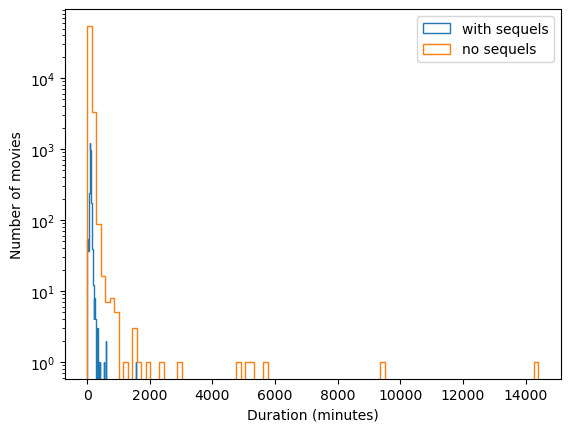

In [55]:
# Plotting histograms to compare the runtime of movies with and without sequels
n_bins = 100  # Number of bins for the histogram

# Histogram for movies with sequels
plt.hist(with_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step", label='with sequels')

# Histogram for movies without sequels
plt.hist(no_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step", label='no sequels')

# Setting labels, legend, and displaying the plot
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

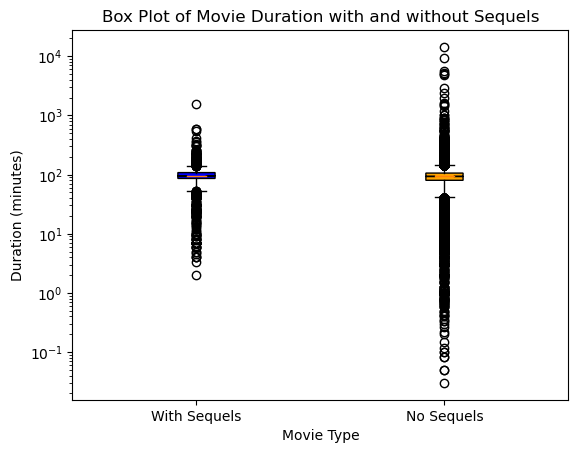

In [56]:
# Creating a box plot to compare the runtime of movies with and without sequels

# Combining duration data into a list for the box plot
duration_data = [with_sequels_duration['Runtime'], no_sequels_duration['Runtime']]

# Setting labels and title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Duration (minutes)')
plt.title('Box Plot of Movie Duration with and without Sequels')

# Setting the y-axis to a logarithmic scale to better display a wide range of durations
plt.yscale('log')

# Customizing the box plots with colors
box_colors = ['blue', 'orange']
# Coloring each box in the box plot
for box, color in zip(plt.boxplot(duration_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)['boxes'], box_colors):
    box.set_facecolor(color)

# Displaying the plot
plt.show()

Let's look at the data for both categories more closely and get some numbers.

In [69]:
# Generating a statistical summary of the 'Runtime' column for movies without sequels
no_sequels_duration['Runtime'].describe()

# This will output key statistics such as:
# - count: The number of non-null entries.
# - mean: The average runtime.
# - std: Standard deviation, indicating how spread out the runtimes are.
# - min: The shortest runtime.
# - 25%, 50%, 75%: The 25th, 50th (median), and 75th percentile runtimes.
# - max: The longest runtime.

# These statistics will help understand the distribution and central tendencies of movie durations in this category.

count    57865.000000
mean        93.962255
std         93.391836
min          0.000000
25%         80.000000
50%         93.000000
75%        106.000000
max      14400.000000
Name: Runtime, dtype: float64

In [70]:
# Generating a statistical summary of the 'Runtime' column for movies with sequels
with_sequels_duration['Runtime'].describe()

count    3426.000000
mean       98.422834
std        42.194757
min         2.000000
25%        86.000000
50%        95.000000
75%       108.000000
max      1560.000000
Name: Runtime, dtype: float64

We have identified outliers in our data, which contains both very long and very short movies. Upon further investigation, we've uncovered a new category of movies that wasn't initially considered. Let's see what our longest movie is.

In [71]:
# Identifying the movie(s) without sequels that have the maximum runtime
no_sequels_duration[no_sequels_duration['Runtime'] == no_sequels_duration['Runtime'].max()]

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
62962,32441022,/m/0gyr803,Modern Times Forever,NaN,NaN,14400.0,{},{},"{""/m/0jtdp"": ""Documentary""}"


In our investigation of this movie, we came across this [wikipedia page](https://en.wikipedia.org/wiki/List_of_longest_films), specifically dedicated to the longest films. However, this category poses challenges for standard plotting. Additionally, it's worth noting that certain entries, like Swallow the Sun, may not fit the conventional definition of a movie, as it is a Korean drama spanning 25 episodes.

At the same time, our dataset contains very short movies. Let's learn more about the shortest.

In [72]:
# Identifying the movie(s) without sequels that have the minimum runtime
no_sequels_duration[no_sequels_duration['Runtime'] == no_sequels_duration['Runtime'].min()]

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,1894,NaN,0.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film""}"


As usual, we turned to Wikipedia to help with our investigation. On the [dedicated wikipedia page](https://fr.wikipedia.org/wiki/Dickson_Experimental_Sound_Film), we can see that our shortest movie is The "Dickson Experimental Sound Film", which is an early attempt at synchronized sound and motion pictures, featuring Dickson playing the violin while two men dance. The movie only lasts 17 seconds.

We are now aware that our data contains movies that do not necessarily fit our definition in terms of duration, either because they are too long or too short. For that, we need a more precise definition in terms of duration, which will be our base for filtering out outliers. Hence, we need to define a minimum and maximum duration for our movies before we continue our analysis. We came across the notion of a [feature film](https://en.wikipedia.org/wiki/Feature_film), which seems to be more consistent with our vision when we deciced to conduct this analysis.

For a more rigourous definition, we can turn to people who are a bit more cinephile than us. For example, in the same page, we learned that the Academy of Motion Picture Arts and Sciences, the American Film Institute and the British Film Institute all agree to set the minimum duration for a feature film to 40 minutes. We did not come across a maximum duration, but we decided that movies in our dataset should not be longer than 5 hours, or 300 minutes. Let's see the percentage of movies that fit into this definition in our two categories.

In [73]:
# Filtering movies to include only those with runtimes between 40 and 300 minutes
filtered_with_sequels_duration = with_sequels_duration[(with_sequels_duration['Runtime'] >= 40) & (with_sequels_duration['Runtime'] < 300)]
filtered_no_sequels_duration = no_sequels_duration[(no_sequels_duration['Runtime'] >= 40) & (no_sequels_duration['Runtime'] < 300)]

In [74]:
# Calculating and displaying the percentage of movies within the specified runtime range
print(f'Percentage of movies with sequels with length between 40 minutes and 300 minutes in the dataset : {len(filtered_with_sequels_duration) / len(with_sequels_duration):.2f}')
print(f'Percentage of movies with no sequels with length between 40 minutes and 300 minutes in the dataset : {len(filtered_no_sequels_duration) / len(no_sequels_duration):.2f}')

Percentage of movies with sequels with length between 40 minutes and 300 minutes in the dataset : 0.96
Percentage of movies with no sequels with length between 40 minutes and 300 minutes in the dataset : 0.92


We can see that after filtering "outliers" in both categories, we still get to keep 96% of movies with sequels and 92% of movies with no sequels. Let's now plot the Box Plot again to get a better grasp of the distribution of the duration of our filtered movies. 

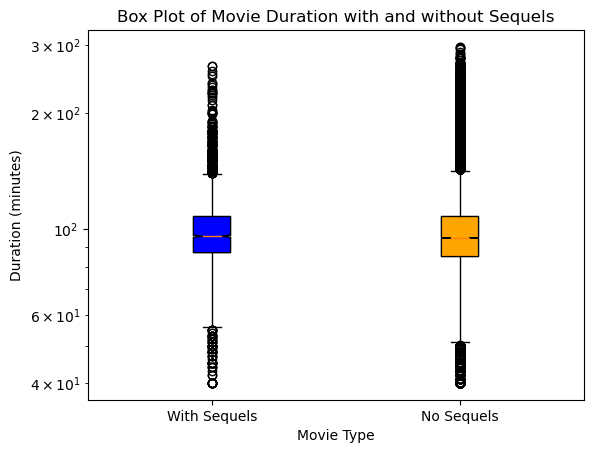

In [63]:
# Combine the duration data into a list for box plot creation
duration_data = [filtered_with_sequels_duration['Runtime'], filtered_no_sequels_duration['Runtime']]

# Set labels for the axes and a title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Duration (minutes)')
plt.title('Box Plot of Movie Duration with and without Sequels')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add colors to the box plots
box_colors = ['blue', 'orange']
for box, color in zip(plt.boxplot(duration_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)['boxes'], box_colors):
    box.set_facecolor(color)

# Show the plot
plt.show()

Let's perform a t-test to see if there is a significant difference in the mean of the duration of feature films with sequels and feature films without sequels.

In [64]:
# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(filtered_with_sequels_duration['Runtime'], filtered_no_sequels_duration['Runtime'], equal_var=False)

# Print the results
print(f'T-test Statistic: {t_stat}')
print(f'P-value: {p_value}')

# Define the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in duration between (filtered) movies with sequels and without sequels.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in duration between (filtered) movies with sequels and without sequels.')


T-test Statistic: 2.6466075005227463
P-value: 0.008164120246546143
Reject the null hypothesis: There is a significant difference in duration between (filtered) movies with sequels and without sequels.


### Month of release

In our dataset, some of the date entries are recorded as just years, while others include both years and months. Our initial task will be to extract the month component from those entries that include both the year and the month. This step is crucial for any subsequent analysis that requires month-level granularity in the date information.

In [65]:
# Extract the month from the ReleaseDate column for movies with and without sequels
df_has_sequels.loc[:,'Month'] = pd.to_datetime(df_has_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.month
df_no_sequels.loc[:,'Month'] = pd.to_datetime(df_no_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.month

# Drop rows with missing month data for movies with and without sequels
with_sequels_months = df_has_sequels.dropna(subset=['Month'])
no_sequels_months = df_no_sequels.dropna(subset=['Month'])

In [75]:
# Counting the occurrences of each month in the datasets of movies with and without sequels
count_months_sequels = with_sequels_months.groupby('Month')['Month'].count()
count_months_no_sequels = no_sequels_months.groupby('Month')['Month'].count()

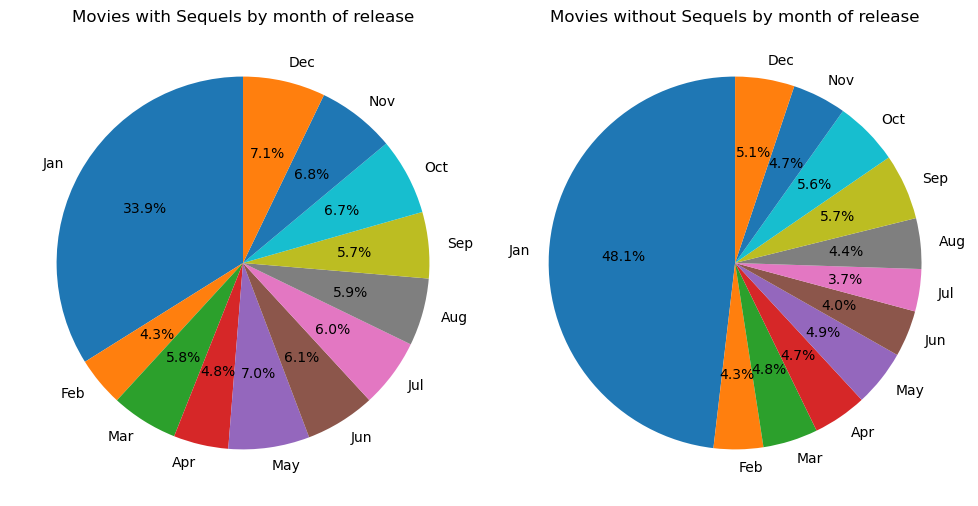

In [76]:
# Preparing month abbreviations
months = list(map(lambda x: calendar.month_abbr[x], np.arange(1,13)))

# Calculating the percentage distribution of movies by month for both categories
percent_sequels = count_months_sequels / count_months_sequels.sum() * 100
percent_no_sequels = count_months_no_sequels / count_months_no_sequels.sum() * 100

# Creating a pie chart for the distribution of movies with sequels by month of release
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(percent_sequels, labels=months, autopct='%1.1f%%', startangle=90)
plt.title('Movies with Sequels by month of release')

# Creating a pie chart for the distribution of movies without sequels by month of release
plt.subplot(1, 2, 2)
plt.pie(percent_no_sequels, labels=months, autopct='%1.1f%%', startangle=90)
plt.title('Movies without Sequels by month of release')

# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()

### Year of release

In this section, we turn our attention to the year of release for movies in our dataset. By examining the distribution of films across different years, we aim to uncover some insights into the evolution of the film industry over time, highlighting periods of heightened activity in sequel production or identifying eras with a predominant focus on original filmmaking. 

In [68]:
# Extract the year from the ReleaseDate column for movies with and without sequels
df_has_sequels.loc[:,'Year'] = pd.to_datetime(df_has_sequels['ReleaseDate'], format='mixed').dt.year
df_no_sequels.loc[:,'Year'] = pd.to_datetime(df_no_sequels['ReleaseDate'], format='mixed').dt.year

# Extract the year from the dataset, will be useful later
cmu_movies.loc[:,'Year'] = pd.to_datetime(cmu_movies['ReleaseDate'], format='mixed').dt.year
movie_per_year = cmu_movies.groupby('Year')['Year'].count()

# Drop rows with missing year data for movies with and without sequels
with_sequels_year = df_has_sequels.dropna(subset=['Year'])
no_sequels_year = df_no_sequels.dropna(subset=['Year'])

ValueError: time data '1964-08-27' does not match format 'mixed' (match)

In [77]:
# Plotting histograms to compare the release years of movies with and without sequels
n_bins = 100  # Number of bins for the histogram

# Histogram for movies with sequels
plt.hist(with_sequels_year['Year'], bins=n_bins, log=True, histtype="step", label='with sequels')

# Histogram for movies without sequels
plt.hist(no_sequels_year['Year'], bins=n_bins, log=True, histtype="step", label='no sequels')

# Setting labels, legend, and displaying the plot
plt.xlabel('Year of release')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

NameError: name 'with_sequels_year' is not defined

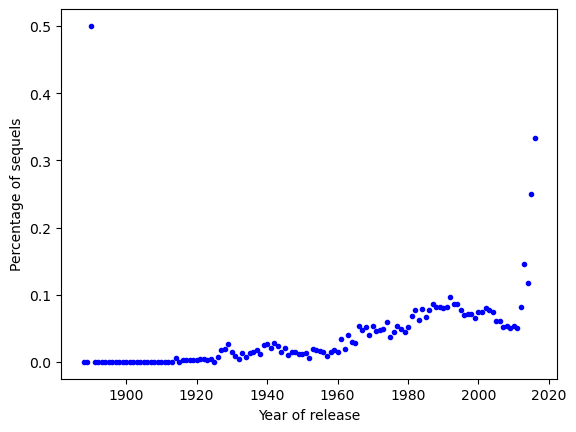

In [ ]:
# Plotting the percentage of movies with and without sequels per year
sequels_per_year = with_sequels_year.groupby('Year')['Year'].count()
no_sequels_per_year = no_sequels_year.groupby('Year')['Year'].count()

# Create a new array with data for all years
all_years = np.arange(cmu_movies['Year'].min(), cmu_movies['Year'].max() + 1)

# Fill in missing values with zeros
sequels_per_year = sequels_per_year.reindex(all_years, fill_value=0)
no_sequels_per_year = no_sequels_per_year.reindex(all_years, fill_value=0)

# Plot the percentage of sequels per year
plt.plot(all_years, sequels_per_year/(sequels_per_year + no_sequels_per_year), 'b.')
plt.xlabel('Year of release')
plt.ylabel('Percentage of sequels')
plt.show()

The plot appears to indicate a rising trend, but before delving deeper, let's examine the distribution within our dataset. 

In [78]:
# Converting the 'ReleaseDate' column to datetime and extracting the year
cmu_movies.loc[:,'Year'] = pd.to_datetime(cmu_movies['ReleaseDate'], format='mixed').dt.year

# Grouping the dataset by year and counting the number of movies released each year
movie_per_year = cmu_movies.groupby('Year')['Year'].count()

ValueError: time data '2001-08-24' does not match format 'mixed' (match)

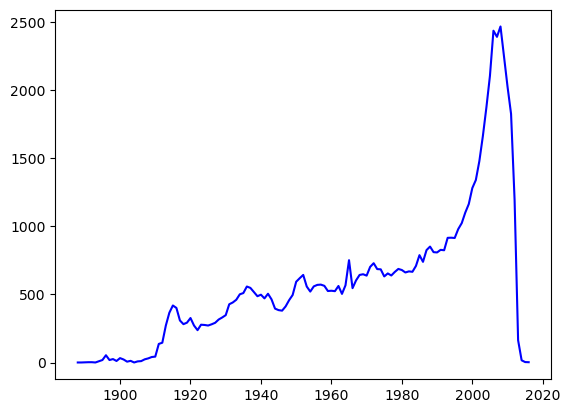

In [ ]:
# Plotting the number of movies released each year
plt.plot(all_years, movie_per_year, 'b-')

It appears that the dataset has fewer entries after the year 2013. Therefore, for a more accurate analysis, we should limit our exploration of trends to data up to the year 2013. Additionally, the year 1890 stands out as an outlier concerning sequels, with only two movies recorded during that year, and one of them being a sequel.

The slope is  : [[0.000761]]


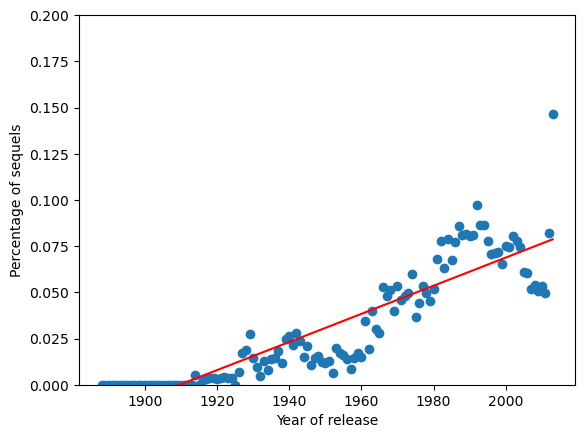

In [ ]:
# Analyzing and plotting the percentage of movies with sequels per year up to 2013
sequels_per_year_b2013 = with_sequels_year[with_sequels_year['Year'] <= 2013].groupby('Year')['Year'].count()
no_sequels_per_year_b2013 = no_sequels_year[no_sequels_year['Year'] <= 2013].groupby('Year')['Year'].count()

# Creating an array of years for the analysis period
all_years_b2013 = np.arange(cmu_movies['Year'].min(), 2014)

# Filling missing year values with zeros for a consistent time series
sequels_per_year_b2013 = sequels_per_year_b2013.reindex(all_years_b2013, fill_value=0)
no_sequels_per_year_b2013 = no_sequels_per_year_b2013.reindex(all_years_b2013, fill_value=0)

# Correcting an outlier in the data
sequels_per_year_b2013.iloc[2] = 0

# Performing linear regression to analyze the trend of sequels over time
lr = LinearRegression()
x = all_years_b2013.reshape(-1, 1)  # Year data as input
y = (sequels_per_year_b2013 / (sequels_per_year_b2013 + no_sequels_per_year_b2013)).values.reshape(-1, 1)  # Percentage of sequels as output
lr.fit(x, y)
y_hat = lr.predict(x)  # Predicted values

print(f'The slope is  : {lr.coef_}')

# Plotting the actual and predicted percentages of sequels per year
plt.scatter(all_years_b2013, sequels_per_year_b2013 / (sequels_per_year_b2013 + no_sequels_per_year_b2013))
plt.plot(all_years_b2013, y_hat, 'r-')  # Predicted trend line
plt.xlabel('Year of release')
plt.ylabel('Percentage of sequels')

# Limiting the y-axis as the plot represents percentages
plt.ylim(0, 0.20)
plt.show()

By fitting a linear regression to the available data, we observe a positive slope. However, the plot suggests a more sinusoidal trend. It's important to note that attempting to predict future trends with such limited information may not yield meaningful results. The nature of the data, especially if it appears sinusoidal, may require more sophisticated modeling techniques for accurate predictions. 

### Country of Origin

This section examines the country of origin for movies in our dataset. We aim to identify trends in film production across different countries and understand how a film's origin correlates with its likelihood of having a sequel. This analysis provides insights into regional film industry dynamics.

In [100]:
# Filtering out movies without country information from the datasets of films with and without sequels
with_sequels_countries = df_has_sequels.dropna(subset=['Countries'])
no_sequels_countries = df_no_sequels.dropna(subset=['Countries'])

Let's randomly pick a movie and see how the countries of origin are represented in the dataset.

In [101]:
# Printing the 'Countries' value and its data type for the 43rd entry in the dataset of films with sequels
print(with_sequels_countries.iloc[42]['Countries'])
print(type(with_sequels_countries.iloc[42]['Countries']))

{"/m/09c7w0": "United States of America"}
<class 'str'>


This representation as a string is not ideal to conduct our analysis, let's switch it for a more efficient one.

In [81]:
# Defining a function to parse the 'Countries' column from JSON string to a list of country names
def parse_countries(country_str):
    try:
        # Convert the string to a dictionary and return the list of country names
        country_dict = json.loads(country_str)
        return list(country_dict.values())
    except json.JSONDecodeError:
        # In case of parsing error, return an empty list
        return []

# Applying the parsing function to the 'Countries' column in both datasets
with_sequels_countries['Countries'] = with_sequels_countries['Countries'].apply(parse_countries)
no_sequels_countries['Countries'] = no_sequels_countries['Countries'].apply(parse_countries)

We know that movies can have many countries of origin, combining different regions across the world. Let's take a closer look at the distribution.

In [82]:
# Generating a statistical summary of the 'Countries' column for movies with sequels
with_sequels_countries['Countries'].describe()

count                           3836
unique                           275
top       [United States of America]
freq                            1692
Name: Countries, dtype: object

In [85]:
# Generating a statistical summary of the 'Countries' column for movies without sequels
no_sequels_countries['Countries'].describe()

count                          77905
unique                          2059
top       [United States of America]
freq                           28608
Name: Countries, dtype: object

Our analysis reveals that there are 275 unique combinations of origin countries for movies with sequels, and 2059 for those without sequels. Intriguingly, the most frequently occurring 'combination' of origin in our dataset is, in fact, a single country - the United States of America. This 'combination' appears 1692 times in movies with sequels and 28608 times in movies without sequels.
 
This is a nuanced observation: while the USA often appears on its own as a country of origin, we suspect that numerous other combinations also feature the USA alongside different countries. This distinction points to the USA's dominant role in film production, both as a solitary player and in international partnerships. Now, we will delve deeper to ascertain the most frequent individual country of origin across all movies, furthering our understanding of global film production trends.

In [86]:
# Use explode() and value_counts() to get the frequency of each country
country_frequency_with_sequels = with_sequels_countries['Countries'].explode().value_counts()

# Get the most frequent country and its frequency
most_frequent_country_with_sequels = country_frequency_with_sequels.idxmax()
most_frequent_country_freq_with_sequels = country_frequency_with_sequels.max()

# Output the results
print(f"Most frequent country in movies with sequels: {most_frequent_country_with_sequels}")
print(f"Frequency of {most_frequent_country_with_sequels}: {most_frequent_country_freq_with_sequels}")

Most frequent country in movies with sequels: United States of America
Frequency of United States of America: 2124


In [87]:
# Use explode() and value_counts() to get the frequency of each country
country_frequency_no_sequels = no_sequels_countries['Countries'].explode().value_counts()

# Get the most frequent country and its frequency
most_frequent_country_no_sequels = country_frequency_no_sequels.idxmax()
most_frequent_country_freq_no_sequels = country_frequency_no_sequels.max()

# Output the results
print(f"Most frequent country in movies without sequels: {most_frequent_country_no_sequels}")
print(f"Frequency of {most_frequent_country_no_sequels}: {most_frequent_country_freq_no_sequels}")

Most frequent country in movies without sequels: United States of America
Frequency of United States of America: 32284


In [88]:
# Calculating and printing the percentage of movies with and without sequels where the USA is one of the countries of origin
print(f'Percentage of movies with sequels where the USA is one of the countries of Origin : {most_frequent_country_freq_with_sequels / len(with_sequels_countries) * 100:.2f}%')
print(f'Percentage of movies with no sequels where the USA is one of the countries of Origin : {most_frequent_country_freq_no_sequels / len(no_sequels_countries) * 100:.2f}%')

Percentage of movies with sequels where the USA is one of the countries of Origin : 55.37%
Percentage of movies with no sequels where the USA is one of the countries of Origin : 41.44%


It seems like we found something interesting here: even though the USA is the top original countries for both movies with and without sequels, it looks like movies with sequels are more likely to have the USA appear in their countries of origin. Let's perform a test to investigate more. We choose to perform a Fisher exact test because it works well with frequency data, which involves counts of occurrences. In our analysis, this is relevant for evaluating how often the USA appears as a country of origin in movies with and without sequels

In [90]:
from scipy.stats import fisher_exact

# number of movies with sequels without USA as origin
with_sequels_non_usa = len(with_sequels_countries) - most_frequent_country_freq_with_sequels

# number of movies without sequels without USA as origin
without_sequels_non_usa = len(no_sequels_countries) - most_frequent_country_freq_no_sequels

# Creating the contingency table
contingency_table = [[most_frequent_country_freq_with_sequels, with_sequels_non_usa], 
                     [most_frequent_country_freq_no_sequels, without_sequels_non_usa]]

# Perform Fisher exact test
oddsratio, p_value = fisher_exact(contingency_table)

# Output the results
print(f"Odds Ratio: {oddsratio}")
print(f"P-value: {p_value}")

# Decision based on p-value
alpha = 0.05
if p_value < alpha:
    print(f"We reject the null hypothesis at the {alpha} significance level.")
    conclusion = "This suggests a significant association between movies having a sequel and the presence of the USA as a country of origin."
else:
    print(f"We fail to reject the null hypothesis at the {alpha} significance level.")
    conclusion = "This indicates that there is no significant association between movies having a sequel and the presence of the USA as a country of origin."

print(conclusion)

Odds Ratio: 1.753186888676084
P-value: 3.5215912389231104e-64
We reject the null hypothesis at the 0.05 significance level.
This suggests a significant association between movies having a sequel and the presence of the USA as a country of origin.


Now, let's put the USA aside and take a closer look at which other countries tend to appear as countries of origin.

In [91]:
# Counting the number of unique countries in the datasets for movies with and without sequels
num_unique_countries_with_sequels = len(with_sequels_countries['Countries'].explode().unique())
num_unique_countries_no_sequels = len(no_sequels_countries['Countries'].explode().unique())

# Printing the number of unique countries for each category of movies
print(f"Number of unique countries in movies with sequels: {num_unique_countries_with_sequels}")
print(f"Number of unique countries in movies without sequels: {num_unique_countries_no_sequels}")

Number of unique countries in movies with sequels: 71
Number of unique countries in movies without sequels: 148


Let's visualize what the top countries are in both categories. For readability, let's focus on the top-20 countries.

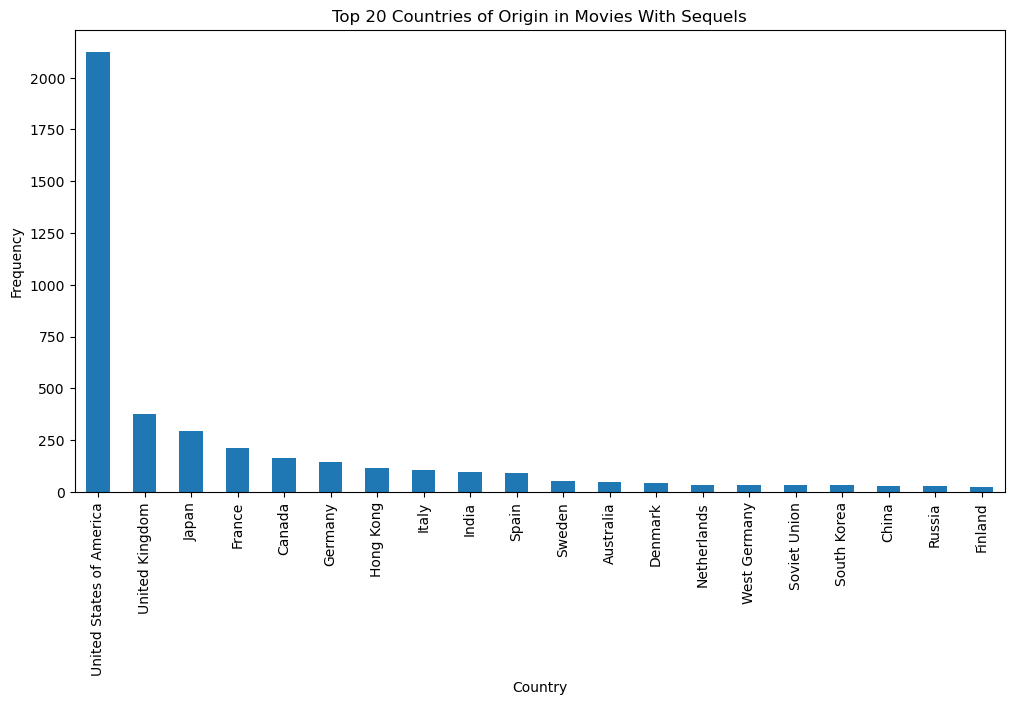

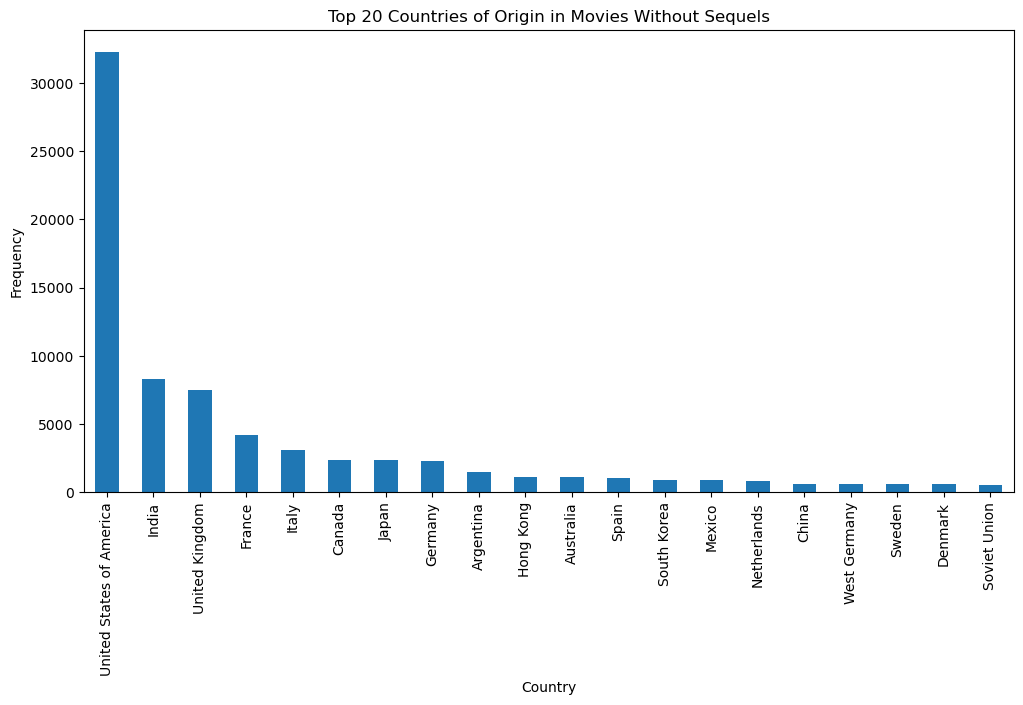

In [92]:
# Count the frequency of each country for movies with sequels
country_freq_with_sequels = with_sequels_countries['Countries'].explode().value_counts()

# Count the frequency of each country for movies without sequels
country_freq_no_sequels = no_sequels_countries['Countries'].explode().value_counts()

# Select the top 20 countries for movies with sequels
top_countries_with_sequels = country_freq_with_sequels.head(20)

# Select the top 20 countries for movies without sequels
top_countries_no_sequels = country_freq_no_sequels.head(20)

# Plot for the top 20 countries in movies with sequels
plt.figure(figsize=(12, 6))
top_countries_with_sequels.plot(kind='bar')
plt.title('Top 20 Countries of Origin in Movies With Sequels')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the country names for better readability

# Show the plot
plt.show()

# Plot for the top 20 countries in movies without sequels
plt.figure(figsize=(12, 6))
top_countries_no_sequels.plot(kind='bar')
plt.title('Top 20 Countries of Origin in Movies Without Sequels')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the country names for better readability

# Show the plot
plt.show()

It is quite difficult to compare the two bar plots as they are not scaled. Let's compare the movies with and without sequels when looking at the percentage of movie per country. As the top countries are not exactly the same, we grouped the 22 countries that appear at least once in the top list.

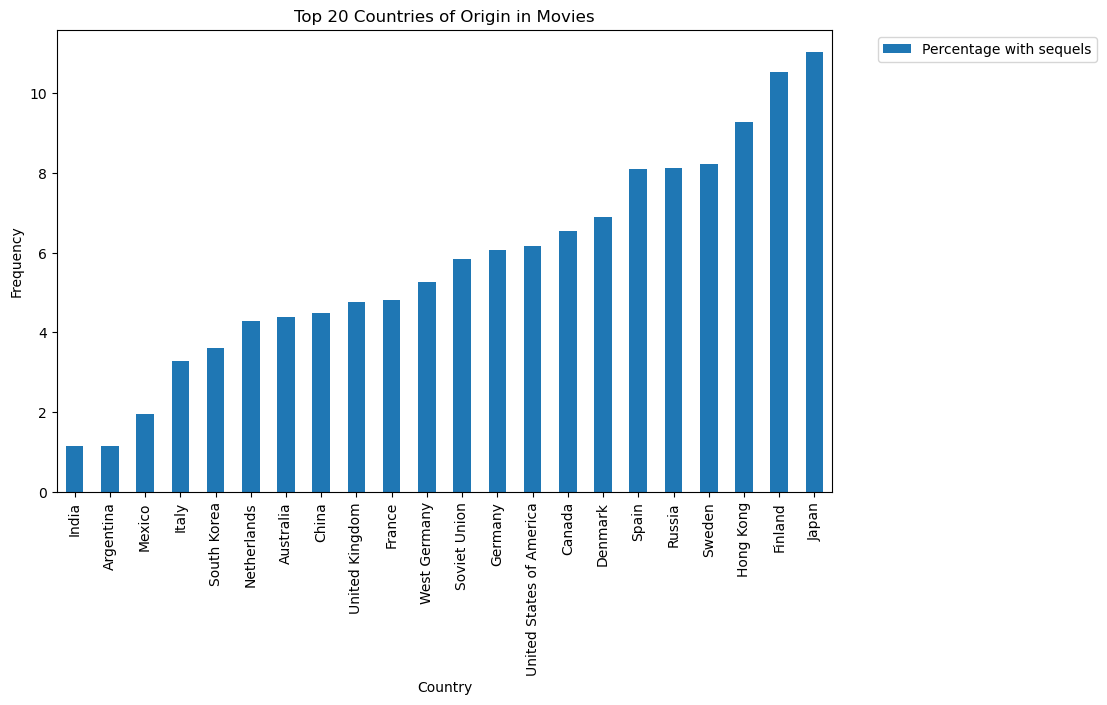

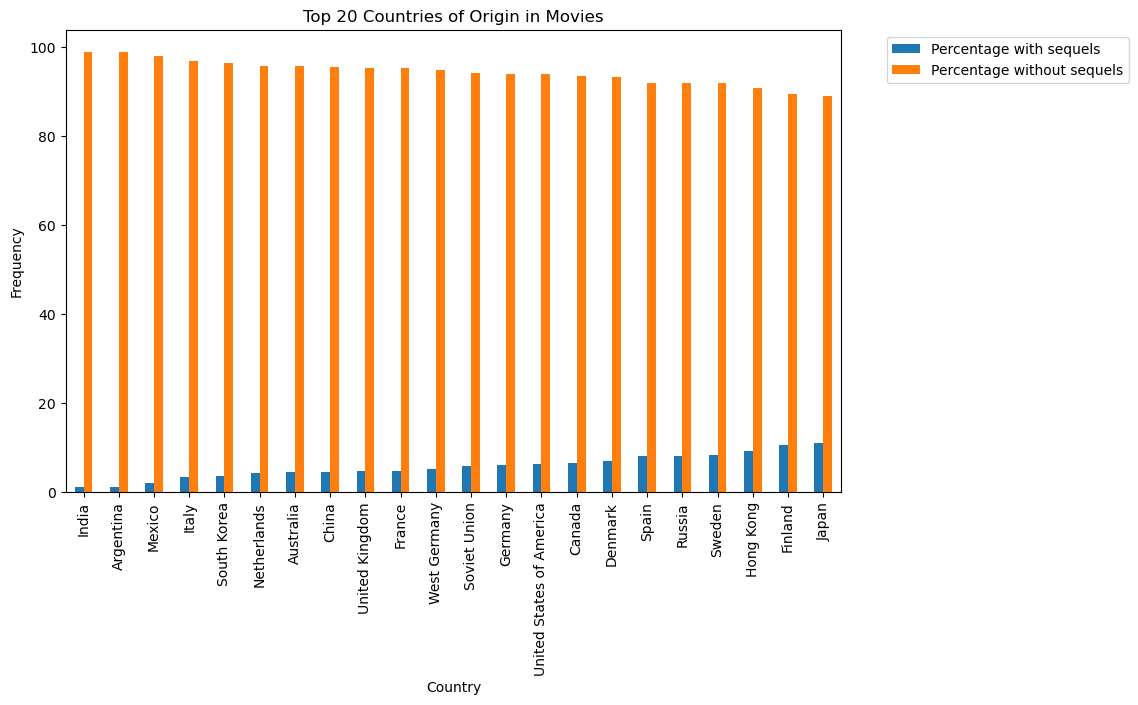

In [93]:
# Top 22 countries for movies with or without sequels
top_countries = ['United States of America', 'India', 'United Kingdom', 'France', 'Italy', 'Canada', 'Japan', 'Germany', 'Argentina', 'Hong Kong', 'Australia', 
                 'Spain', 'South Korea', 'Mexico', 'Netherlands', 'China', 'West Germany', 'Sweden', 'Denmark', 'Soviet Union', 'Russia', 'Finland']

# Create a dataframe that contains the percentage of movies made in each country 
country_freq_with_sequels_sum = 0
country_freq_without_sequels_sum = 0
df_countries = pd.DataFrame(index=top_countries, columns=['Percentage with sequels', 'Percentage without sequels'], data=0).astype(float)
for i, country in enumerate(top_countries):
    nb_of_movie = 0
    nb_of_movie += country_freq_with_sequels[country]
    nb_of_movie += country_freq_no_sequels[country]
    df_countries.iloc[i,0] = country_freq_with_sequels[country]/nb_of_movie * 100
    df_countries.iloc[i,1] = country_freq_no_sequels[country]/nb_of_movie * 100

# Plot for the top 22 countries in movies
ax = df_countries.sort_values(by='Percentage with sequels')['Percentage with sequels'].plot(kind='bar', figsize=(10, 6), rot=0)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Top 20 Countries of Origin in Movies')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the country names for better readability
plt.show()

# Plot for the top 22 countries in movies
ax = df_countries.sort_values(by='Percentage with sequels').plot(kind='bar', figsize=(10, 6), rot=0)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Top 20 Countries of Origin in Movies')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the country names for better readability
plt.show()

In [95]:
from scipy.stats import kstest

# Performing the Kolmogorov-Smirnov test
ks_result = kstest(df_countries['Percentage with sequels'], df_countries['Percentage without sequels'])

# Interpreting and printing the conclusion of the test
p_value = ks_result.pvalue
if p_value < 0.05:
    print(f"Significant difference found (p-value = {p_value:.4f}). The distribution of percentages of movies with sequels is statistically different from those without sequels across countries.")
else:
    print(f"No significant difference found (p-value = {p_value:.4f}). The distribution of percentages of movies with and without sequels is statistically similar across countries.")

Significant difference found (p-value = 0.0000). The distribution of percentages of movies with sequels is statistically different from those without sequels across countries.


What about the number of countries of origin per movie?

In [96]:
# Adding a new column to count the number of countries of origin for each movie in both datasets
with_sequels_countries['num_countries'] = with_sequels_countries['Countries'].apply(lambda x: len(x))
no_sequels_countries['num_countries'] = no_sequels_countries['Countries'].apply(lambda x: len(x))

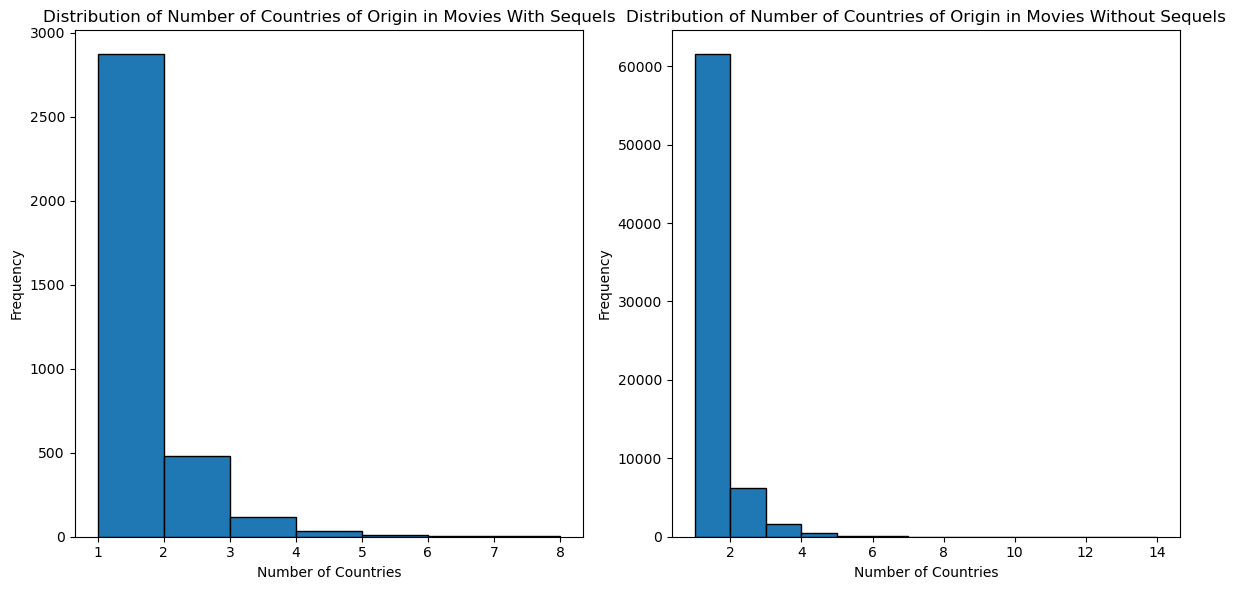

In [98]:
# Count the number of origin countries in each movie
with_sequels_countries['num_countries'] = with_sequels_countries['Countries'].apply(lambda x: len(x))
no_sequels_countries['num_countries'] = no_sequels_countries['Countries'].apply(lambda x: len(x))

# Plotting
plt.figure(figsize=(12, 6))

# Histogram for movies with sequels
plt.subplot(1, 2, 1)
plt.hist(with_sequels_countries['num_countries'], bins=range(1, with_sequels_countries['num_countries'].max() + 1), edgecolor='black')
plt.title('Distribution of Number of Countries of Origin in Movies With Sequels')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')

# Histogram for movies without sequels
plt.subplot(1, 2, 2)
plt.hist(no_sequels_countries['num_countries'], bins=range(1, no_sequels_countries['num_countries'].max() + 1), edgecolor='black')
plt.title('Distribution of Number of Countries of Origin in Movies Without Sequels')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Let's compare the two distributions.

In [99]:
# Performing a Kolmogorov-Smirnov test to compare the distribution of the number of countries of origin in movies with and without sequels
ks_result_countries = kstest(no_sequels_countries['num_countries'], with_sequels_countries['num_countries'])

# Printing the result of the Kolmogorov-Smirnov test for country count distribution
print(ks_result_countries)

# Interpreting the test result and providing a conclusion
p_value_countries = ks_result_countries.pvalue
if p_value_countries < 0.05:
    print(f"Significant difference found (p-value = {p_value_countries:.4f}). The distribution of country counts is statistically different between movies with and without sequels.")
else:
    print(f"No significant difference found (p-value = {p_value_countries:.4f}). The distribution of country counts is statistically similar between movies with and without sequels.")

KstestResult(statistic=0.06001428573436307, pvalue=6.881676913645816e-12, statistic_location=1, statistic_sign=1)
Significant difference found (p-value = 0.0000). The distribution of country counts is statistically different between movies with and without sequels.


We can reject the null hypothesis, indicating that the two distributions may be different.

### Movie genre

In this section, we focus on movie genres within our dataset. Our objective is to uncover patterns in genre distribution among movies with and without sequels. 

In [109]:
# Filtering movies with and without sequels to include only those with genre information
with_sequels_genres = df_has_sequels.dropna(subset=['Genres'])
no_sequels_genres = df_no_sequels.dropna(subset=['Genres'])

We select a random movie to examine how the genres are distributed.

In [110]:
# Printing the genre information for the 43th movie and its data type
print(with_sequels_genres.iloc[42]['Genres'])
print(type(with_sequels_genres.iloc[42]['Genres']))

{"/m/0hj3myq": "Children's/Family", "/m/0hj3n6r": "Holiday Film", "/m/01z4y": "Comedy", "/m/0hj3n62": "Heavenly Comedy", "/m/0hj3myc": "Children's Fantasy"}
<class 'str'>


Let's switch it for a more efficient representation, as we did for the country of origin.

In [111]:
# Parsing and converting genre information in the 'Genres' column to lists of genre names

# Define a function to parse genre information
def parse_genres(genre_str):
    try:
        # Convert the string to a dictionary and write all the genres with lowercase
        genre_dict = json.loads(genre_str.lower())

        # Return the list of genre names
        return list(genre_dict.values())
    except json.JSONDecodeError:
        # In case of parsing error, return an empty list or some default value
        return []

# Update 'Genres' column to contain lists of genre names
with_sequels_genres['Genres'] = with_sequels_genres['Genres'].apply(parse_genres)
no_sequels_genres['Genres'] = no_sequels_genres['Genres'].apply(parse_genres)

We will now explore simplified genres because it seems that some genre names are too specific but share similar meanings. This simplification will aid our analysis by reducing the complexity introduced by highly specific genres.

In [113]:
# Count the frequency of each genre for movies with sequels
genre_freq_with_sequels = with_sequels_genres['Genres'].explode().value_counts()

# Count the frequency of each genre for movies without sequels
genre_freq_no_sequels = no_sequels_genres['Genres'].explode().value_counts()

# Print the top 20 genres for movies with and without sequels
print(f'Top genres for movies with sequels: \n {genre_freq_with_sequels.head(20)} \n')
print(f'Top genres for movies without sequels: \n {genre_freq_no_sequels.head(20)}')

Top genres for movies with sequels: 
 comedy               1081
drama                 938
action                790
thriller              726
adventure             631
horror                616
family film           601
action/adventure      526
animation             475
world cinema          413
crime fiction         408
fantasy               405
science fiction       404
romance film          339
japanese movies       274
children's/family     243
cult                  242
mystery               222
music                 207
short film            204
Name: Genres, dtype: int64 

Top genres for movies without sequels: 
 drama               33069
comedy              15268
romance film         9895
black-and-white      8947
thriller             8018
action               8008
short film           7937
world cinema         6742
indie                6710
crime fiction        6540
documentary          5473
silent film          5234
horror               4664
adventure            4332
comedy f

We can observe that some genres are redundant, such as 'comedy' and 'comedy film,' for example. To address this, we have decided to create a list of 22 genres, which includes the top 20 genres of movies with and without sequels. We will then select all films that contain a genre from this list. For instance, in the case of 'comedy,' both 'comedy' and 'comedy film' will be selected since they share the keyword 'comedy.' Since we transform all genres to lowercase, issues like 'Drama' and 'Romantic drama' will be handled seamlessly. Let's visualize these differences more clearly.

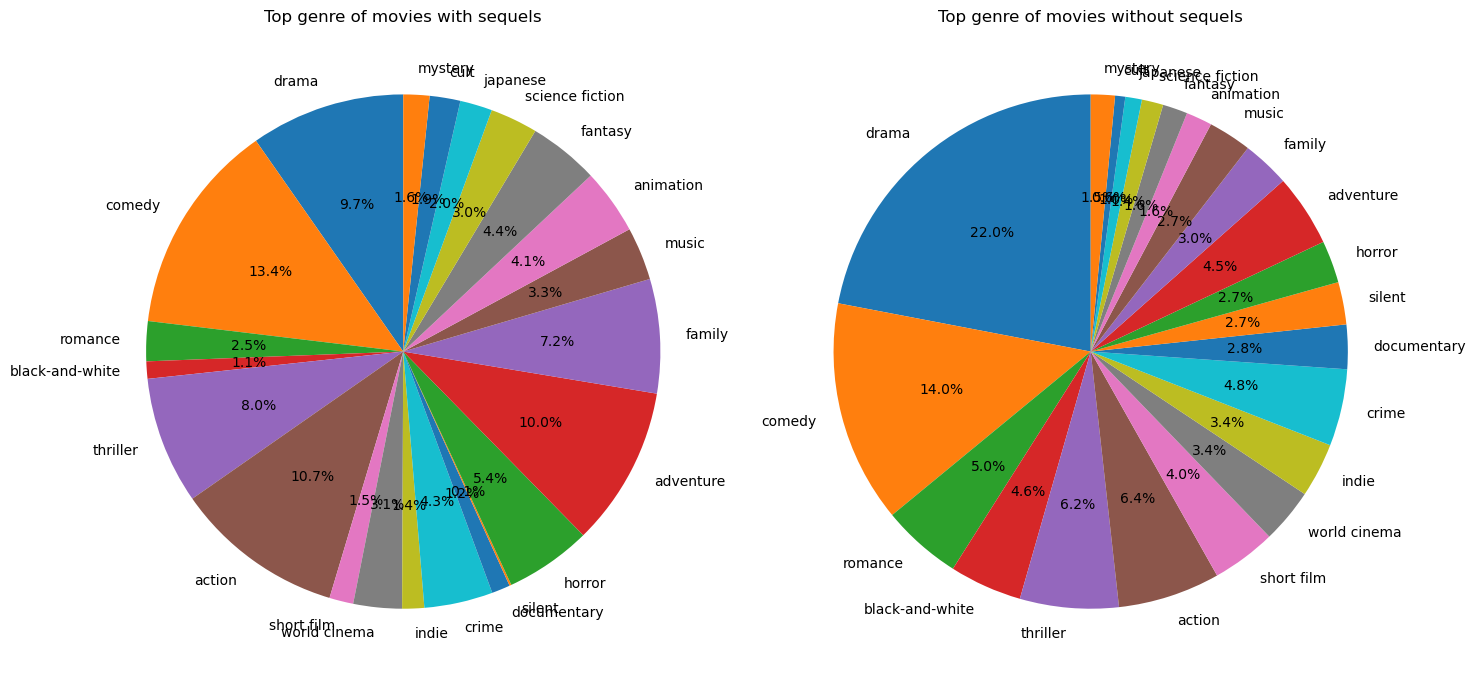

In [114]:
# List of the top genres
top_genres = ['drama', 'comedy', 'romance', 'black-and-white', 'thriller', 'action', 'short film', 'world cinema', 'indie', 'crime', 'documentary', 
              'silent', 'horror', 'adventure', 'family', 'music', 'animation', 'fantasy', 'science fiction', 'japanese', 'cult', 'mystery'] 


# Count the occurrences of each top genre
def count_top_genre(genre_freq_series, top_genre):
    return genre_freq_series[genre_freq_series.index.str.contains(top_genre, case=False)].sum()

# Get the frequency of each top genre
top_genres_freq_with_sequels = [count_top_genre(genre_freq_with_sequels, genre) for genre in top_genres]
top_genres_freq_no_sequels = [count_top_genre(genre_freq_no_sequels, genre) for genre in top_genres]

# Plot pie chart for movies with sequels
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.pie(top_genres_freq_with_sequels, labels=top_genres, autopct='%1.1f%%', startangle=90)
plt.title('Top genre of movies with sequels')

# Plot pie chart for movies with sequels
plt.subplot(1, 2, 2)
plt.pie(top_genres_freq_no_sequels, labels=top_genres, autopct='%1.1f%%', startangle=90)
plt.title('Top genre of movies without sequels')

plt.tight_layout()
plt.show()

Notable differences arise between films with and without sequels. While challenging to fully explain, a plausible factor is the prevalence of genres. 'drama,' commonly found in standalone movies, often features plots less amenable to continuation. Conversely, genres like 'adventure' and 'action' lend themselves to longer or easily extended storylines, potentially driving the likelihood of sequels. The nuanced nature of narrative genres contributes to the complexity of understanding these variations.

Now, we aim to investigate how pairs of genres are linked. For example, is the pair 'comedy/drama' more prevalent in movies with or without sequels? What kind of differences can we observe? To answer this question, let's create heatmaps to visualize the correlation between two genres.

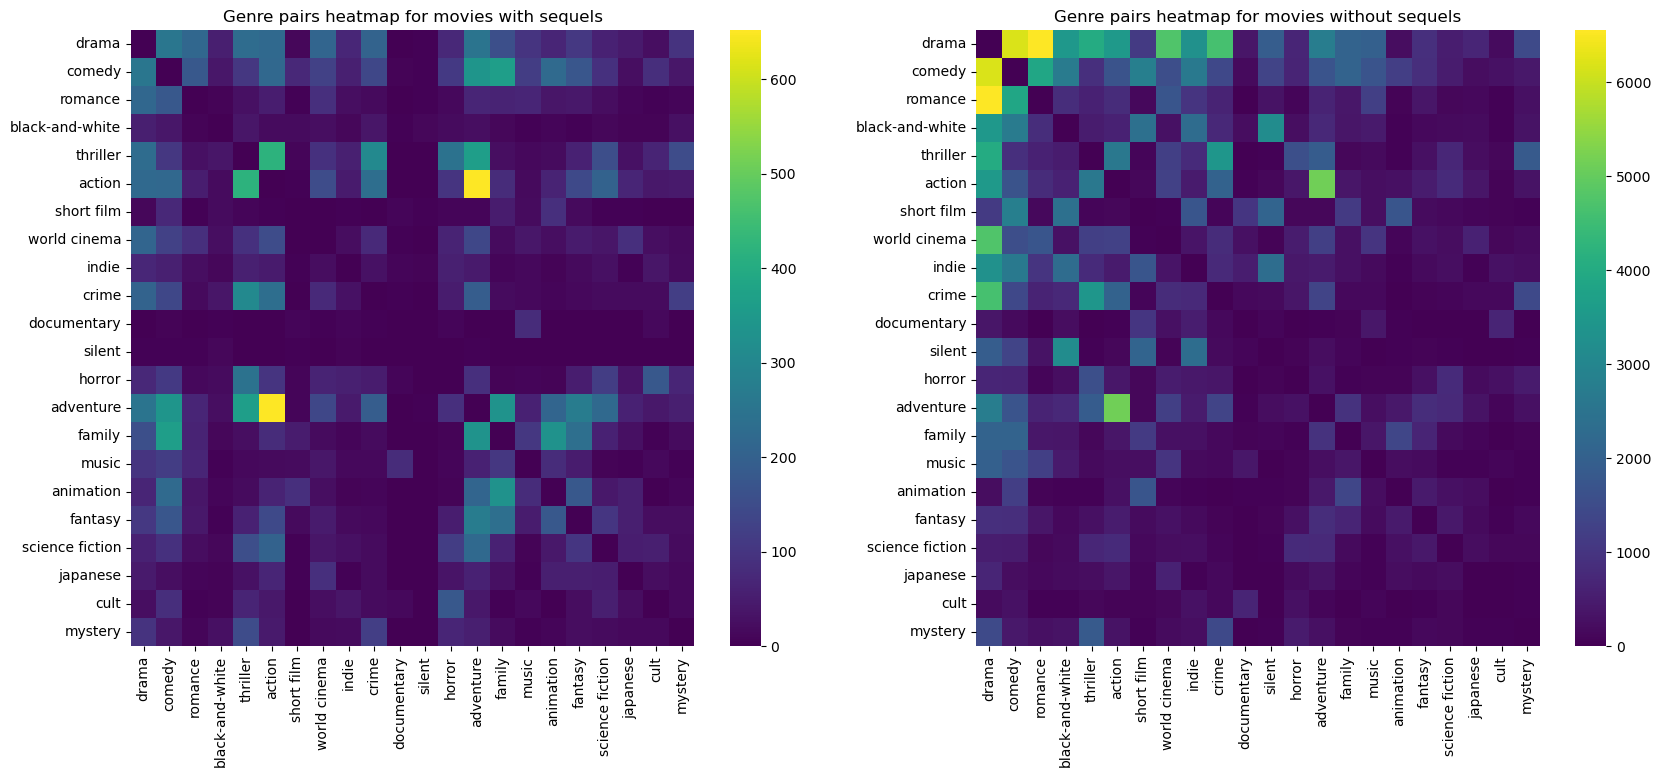

In [115]:
# Check if a pair of genres is present in a movie
def genre_pair_presence(genre_list, genre_pair):
    return all(any(genre in full_genre for full_genre in genre_list) for genre in genre_pair)

# Create a matrix for genre pairs for movie with and without sequels
genre_pair_matrix_with_sequels = pd.DataFrame(index=top_genres, columns=top_genres, data=0)
genre_pair_matrix_no_sequels = pd.DataFrame(index=top_genres, columns=top_genres, data=0)

# Iterate through pairs of genres 
for genre1 in top_genres:
    for genre2 in top_genres:
        if genre1 != genre2:
            genre_pair = [genre1, genre2]
            
            # Check if the pair is present in each movie and count
            genre_pair_matrix_with_sequels.at[genre1, genre2] = len(with_sequels_genres[with_sequels_genres['Genres'].apply(lambda x: genre_pair_presence(x, genre_pair))])
            genre_pair_matrix_no_sequels.at[genre1, genre2] = len(no_sequels_genres[no_sequels_genres['Genres'].apply(lambda x: genre_pair_presence(x, genre_pair))])

# Plot the heatmaps
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(genre_pair_matrix_with_sequels, cmap='viridis', fmt='d', ax=ax1)
sns.heatmap(genre_pair_matrix_no_sequels, cmap='viridis', fmt='d', ax=ax2)
ax1.set_title('Genre pairs heatmap for movies with sequels')
ax2.set_title('Genre pairs heatmap for movies without sequels')
plt.show()

While examining the data, it becomes apparent that movies without sequels exhibit a higher prevalence of correlated genre pairs compared to movies with sequels. In the heatmap representing movies with sequels, we observe a strong correlation between the pairs 'action/adventure' and 'action/thriller'.

### Characters exploration

Let us embark on a captivating exploration of the diverse characters that populate our cinematic world. As we delve into the rich tapestry of personalities, roles, and stories within our movies, we aim to uncover intriguing insights and patterns that illuminate the fascinating realm of characters on the silver screen.

In [116]:
# Read character metadata from the specified TSV file and select relevant columns
all_characters_df = pd.read_csv("movie_summaries/character.metadata.tsv", sep='\t', engine='c', 
                                names = ['WikipediaID', 'MovieReleaseDate', 
                                         'CharacterName', 'ActorDOB', 'ActorGender', 'ActorHeight', 
                                         'ActorName', 'ActorAgeAtRelease', 'FreebaseActorID'],
                                usecols=[0, 2, 3, 4, 5, 6, 8, 9, 12])

# Display summary statistics of the character dataset
all_characters_df.describe()

,WikipediaID,ActorHeight,ActorAgeAtRelease
count,4.506630e+05,154824.000000,292555.000000
mean,1.396956e+07,1.788893,37.819918
std,1.079650e+07,4.379940,14.323909
min,3.300000e+02,0.610000,-937.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366451e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


We can imemdiately see that there are some issue with our data. For example, we can see that our dataset contains at least one negative value for 'ActorAgeAtRelease', which does not make a lot of sense. We also suspect that we will be dealing with some missing values. So we start by defining a method, infer_ages_at_release, which will hopefully help us recover some data related to the age of the actors at the release of the movie, by using the date of birth of the actor and the movie's release date.

In [117]:
# Function to infer and update actor ages at the time of movie release
def infer_ages_at_release(df):
    # Calculate and print the percentage of missing or incorrect actor age at release before inference
    print(f"Percentage of missing or incorrect actor age at release before inferring: {(len(df[(df['ActorAgeAtRelease'].isnull()) | (df['ActorAgeAtRelease'] < 0)])/len(df))*100}%")

    # Iterate through rows with missing or incorrect actor age at release
    for index, row in df[(df['ActorAgeAtRelease'].isnull()) | (df['ActorAgeAtRelease'] < 0)].iterrows():
        # Check if actor date of birth (DOB) and movie release date are not null
        if not pd.isnull(row['ActorDOB']) and not pd.isnull(row['MovieReleaseDate']):
            try:
                # Parse actor's date of birth and movie release date
                dob = pd.to_datetime(row['ActorDOB']).tz_localize(None)
                release_date = pd.to_datetime(row['MovieReleaseDate']).tz_localize(None)
                
                # Calculate actor's age at release and update the DataFrame
                actor_at_release = release_date - dob
                df.loc[index, 'ActorAgeAtRelease'] = floor(actor_at_release.days / 365)
            except:
                print(f"Error in date parsing or calculation - index {index}")

    # Calculate and print the percentage of missing or incorrect actor age at release after inference
    print(f"Percentage of missing or incorrect actor age at release after inferring: {(len(df[(df['ActorAgeAtRelease'].isnull()) | (df['ActorAgeAtRelease'] < 0)])/len(df))*100}%")

# Call the function to infer actor ages at release for the DataFrame
infer_ages_at_release(all_characters_df)

Percentage of missing or incorrect actor age at release before inferring: 35.16574469170977%
Percentage of missing or incorrect actor age at release after inferring: 25.66352241031547%


It looks like we successfully managed to save almost 10% of our data for the age at movie release column. Now, we can start doing some further analysis. As usual, let us create two dataframes, one for movies with sequels, and one for movies without sequels.

In [120]:
# Extract movie IDs
movies_with_sequels_ids = set(df_has_sequels['WikipediaID'])
movies_no_sequels_ids = set(df_no_sequels['WikipediaID'])

# Filter characters based on whether their movie ID is in the sequels or no-sequels list
characters_with_sequels = all_characters_df[all_characters_df['WikipediaID'].isin(movies_with_sequels_ids)]
characters_no_sequels = all_characters_df[all_characters_df['WikipediaID'].isin(movies_no_sequels_ids)]

# Group by WikipediaID
grouped_characters_with_sequels = characters_with_sequels.groupby('WikipediaID')
grouped_characters_no_sequels = characters_no_sequels.groupby('WikipediaID')

#### Gender of the Actors

In this section, we delve into the gender distribution of actors in our dataset. Analyzing the gender of actors provides insights into the diversity of roles and potentially highlights gender-related trends in the film industry.

In [121]:
# Filter out rows with missing actor gender for movies with sequels
with_sequels_gender = characters_with_sequels.dropna(subset=['ActorGender'])

# Filter out rows with missing actor gender for movies without sequels
no_sequels_gender = characters_no_sequels.dropna(subset=['ActorGender'])

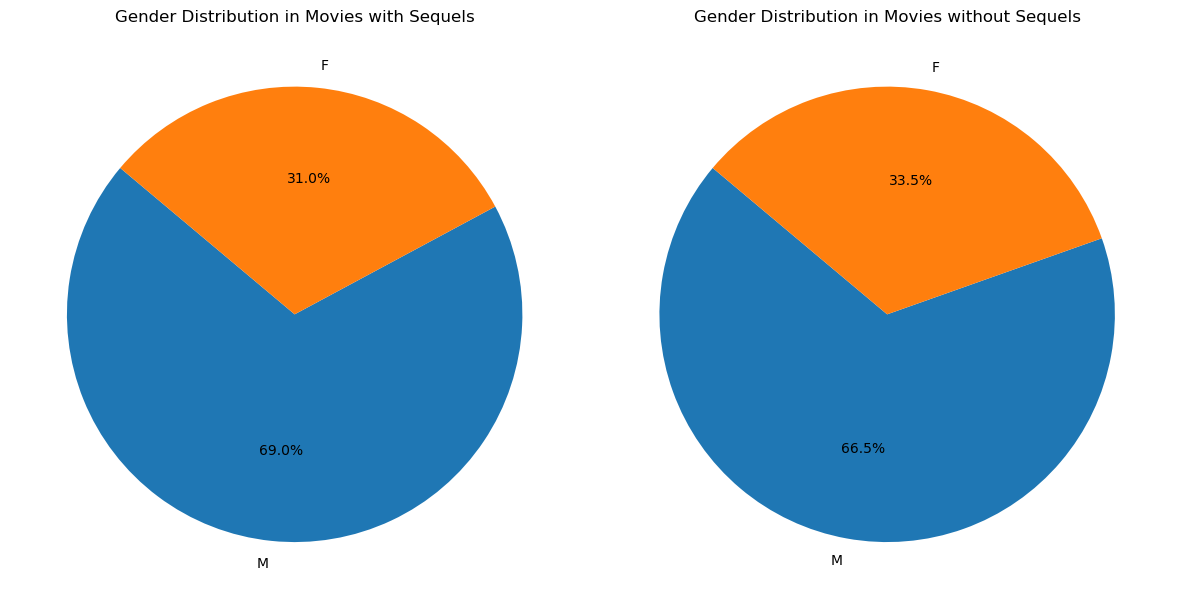

In [122]:
# Define a function to plot gender distribution as pie charts
def plot_gender_distribution_pie(ax, df, title):
    # Calculate counts of each gender
    counts = df['ActorGender'].value_counts()
    
    # Create a pie chart on the specified Axes object
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(title)

# Set up a matplotlib figure for side-by-side plots
plt.figure(figsize=(12, 6))

# Create a subplot for movies with sequels
ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plot_gender_distribution_pie(ax1, with_sequels_gender, 'Gender Distribution in Movies with Sequels')

# Create a subplot for movies without sequels
ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plot_gender_distribution_pie(ax2, no_sequels_gender, 'Gender Distribution in Movies without Sequels')

# Display the plots
plt.tight_layout()
plt.show()

The gender distribution across both movie categories reveals a notable imbalance, with female characters constituting just 31% of the cast in movies with sequels, and marginally higher at 33.5% in movies without sequels. Such figures underscore the persistent underrepresentation of women in the film industry. The increment in female presence within films in the second category, though slight, raises questions about its statistical significance and whether a correlation exists between the propensity of sequels and a reduced proportion of female roles. To evaluate the validity of this observation, we employ a statistical hypothesis test to determine if the difference is indeed significant.

In [123]:
# Convert gender to numeric: 1 for female (F) and 0 for male (M)
numeric_with_sequels = with_sequels_gender['ActorGender'].apply(lambda x: 1 if x == 'F' else 0)
numeric_no_sequels = no_sequels_gender['ActorGender'].apply(lambda x: 1 if x == 'F' else 0)

# Perform the t-test
t_stat, p_value = ttest_ind(numeric_with_sequels, numeric_no_sequels, nan_policy='omit')

# Output the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Conclusion based on the p-value
significance_level = 0.05
if p_value < significance_level:
    print(f'The test results are statistically significant (p < {significance_level}), suggesting a difference in the proportion of female characters between the two movie categories.')
else:
    print(f'The test results are not statistically significant (p >= {significance_level}), indicating no evidence of a difference in the proportion of female characters between the two movie categories.')

T-statistic: -8.793160749191763
P-value: 1.4596150806114725e-18
The test results are statistically significant (p < 0.05), suggesting a difference in the proportion of female characters between the two movie categories.


#### Age of the Actors

Now let us focus on the age of the actors. We have previously managed to fill some of the missing or invalid rows with the age of the actors at the release of the movie, whenever we had the date of birth and release date. However, these information were not always provided, so our dataframes need some further cleaning. We filter out the rows with missing values, and we ensure that the age is between 0 and 120 years.

In [124]:
# Filter and clean actor age data for movies with sequels
with_sequels_age = characters_with_sequels.dropna(subset=['ActorAgeAtRelease'])
with_sequels_age = with_sequels_age[(with_sequels_age['ActorAgeAtRelease'] >= 0) & (with_sequels_age['ActorAgeAtRelease'] < 120)]

# Filter and clean actor age data for movies without sequels
no_sequels_age = characters_no_sequels.dropna(subset=['ActorAgeAtRelease'])
no_sequels_age = no_sequels_age[(no_sequels_age['ActorAgeAtRelease'] >= 0) & (no_sequels_age['ActorAgeAtRelease'] < 120)]

We can now plot the age pyramids for both categories. This will allow us to also see how the age distribution changes as a function of the gender of the actor.

In [126]:
# Create age bins and labels for the age groups
bins = list(range(0, 121, 5))  # Adjust the range and bin width as needed
age_labels = [f'{i}-{i+4}' for i in range(0, 120, 5)]  # Create labels for the age groups

# Bin the age data for movies with sequels
with_sequels_age['AgeGroup'] = pd.cut(with_sequels_age['ActorAgeAtRelease'], bins=bins, labels=age_labels, right=False)
with_sequels_counts = with_sequels_age.groupby(['AgeGroup', 'ActorGender'], observed=False).size().unstack().fillna(0)
more_than_85_no_seq = with_sequels_counts.iloc[-7:].sum()
with_sequels_counts.drop(with_sequels_counts.tail(7).index,inplace=True)
with_sequels_counts.loc['85+'] = [more_than_85_no_seq['F'], more_than_85_no_seq['M']]

# Bin the age data for movies without sequels
no_sequels_age['AgeGroup'] = pd.cut(no_sequels_age['ActorAgeAtRelease'], bins=bins, labels=age_labels, right=False)
no_sequels_counts = no_sequels_age.groupby(['AgeGroup', 'ActorGender'], observed=False).size().unstack().fillna(0)
more_than_85_seq = no_sequels_counts.iloc[-7:].sum()
no_sequels_counts.drop(no_sequels_counts.tail(7).index,inplace=True)
no_sequels_counts.loc['85+'] = [more_than_85_seq['F'], more_than_85_seq['M']]

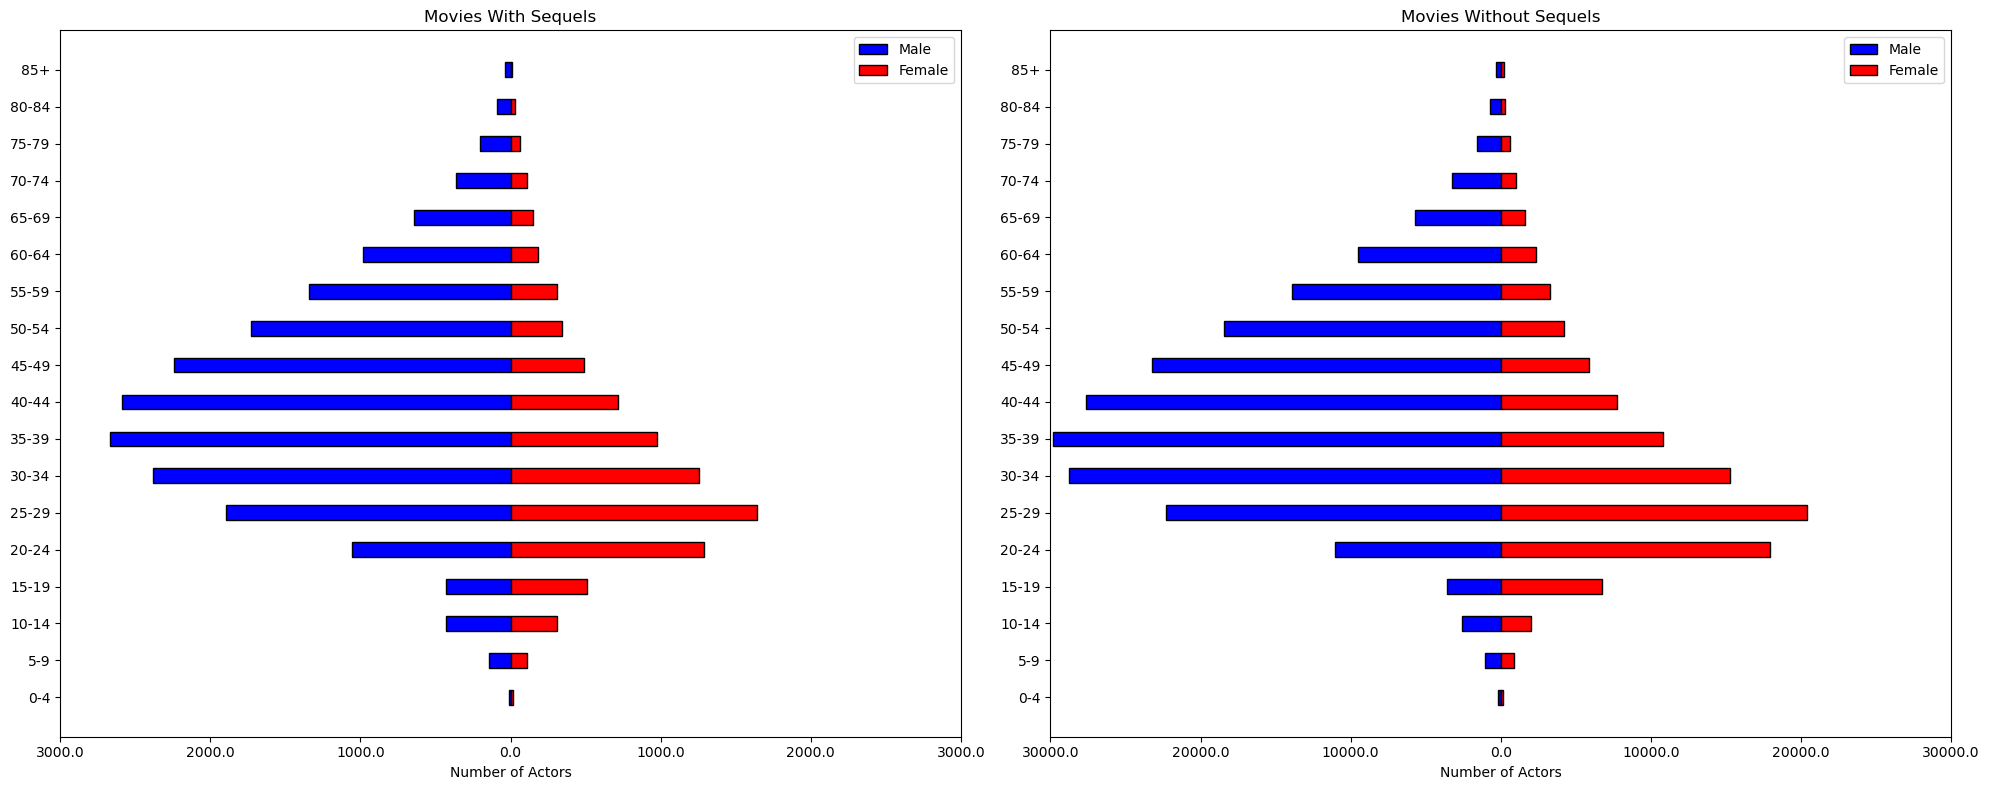

In [127]:
# Plotting the population pyramids
plt.figure(figsize=(20, 8))

# Plot for movies with sequels
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.barh(y=with_sequels_counts.index, width=-with_sequels_counts['M'].abs(), label='Male', color='blue', edgecolor='black', height=0.4)
plt.barh(y=with_sequels_counts.index, width=with_sequels_counts['F'].abs(), label='Female', color='red', edgecolor='black', height=0.4)
plt.xlabel('Number of Actors')
plt.title('Movies With Sequels')
plt.legend()
plt.xlim(-max(with_sequels_counts.max()), max(with_sequels_counts.max()))
ticks = plt.xticks()
plt.xticks(ticks[0], [str(abs(tick)) for tick in ticks[0]])

# Plot for movies without sequels
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.barh(y=no_sequels_counts.index, width=-no_sequels_counts['M'].abs(), label='Male', color='blue', edgecolor='black', height=0.4)
plt.barh(y=no_sequels_counts.index, width=no_sequels_counts['F'].abs(), label='Female', color='red', edgecolor='black', height=0.4)
plt.xlabel('Number of Actors')
plt.title('Movies Without Sequels')
plt.legend()
plt.xlim(-max(no_sequels_counts.max()), max(no_sequels_counts.max()))
ticks = plt.xticks()
plt.xticks(ticks[0], [str(abs(tick)) for tick in ticks[0]])

plt.tight_layout()  # Adjust the layout
plt.show()

The two pyramids look pretty similar, suggesting a similar distribution. Let's get some precise values.

In [128]:
# Calculating mean age of actors with sequels by gender
mean_age_with_sequels = with_sequels_age.groupby('ActorGender')['ActorAgeAtRelease'].mean()

# Calculating mean age of actors without sequels by gender
mean_age_no_sequels = no_sequels_age.groupby('ActorGender')['ActorAgeAtRelease'].mean()

# Displaying the results
print("Mean Age of Actors with Sequels:", mean_age_with_sequels)
print("\nMean Age of Actors without Sequels:")
print(mean_age_no_sequels)

Mean Age of Actors with Sequels: ActorGender
F    33.931378
M    41.568159
Name: ActorAgeAtRelease, dtype: float64

Mean Age of Actors without Sequels:
ActorGender
F    33.568504
M    41.181260
Name: ActorAgeAtRelease, dtype: float64


The data distinctly highlights a notable age disparity between male and female actors in both categories of films—those with sequels and without. In each case, female actors are noticeably younger than their male counterparts. For instance, in movies with sequels, the average age of female actors is around 33.93 years, which is significantly lower than the average age of male actors at approximately 41.57 years. This trend is similarly observed in films without sequels, where female actors have an average age of about 33.57 years, in contrast to male actors who average around 41.18 years. This consistent age gap across different types of films underscores a prevalent industry trend where female actors are, on average, younger than male actors. On the other hand, these numbers suggest a consistent age distribution across both genders, regardless of the presence of sequels, with a marginal increase in average age for actors in sequels.

## Part 2: Comparing the original movies and their sequels

In this section, we will delve into the analysis of original movies and their sequels. While exploring various aspects, we will compare these two groups across several dimensions:

* Earnings
* Duration
* Year of release
* Film genre
* Characters
    * Age
    * Gender

We have decided not to analyze the countries of origin extensively, as they are less likely to change significantly when focusing on original-sequel pairs. Instead, we will concentrate on these key factors to gain insights into the dynamics of movie sequels.

First, we need to merge the `from_csv`dataset to the `cmu_movies`, to add the Wikidata ID of the film and the one of its sequel. 

In [129]:
# Merging the CMU Movies dataset with additional data from a CSV file using the 'WikipediaID' as the common key
cmu_movies_merged = cmu_movies.merge(from_csv, how="left", on='WikipediaID')

Then, we will select the movies with sequels to create the dataset of original movies: `df_originals`.

In [130]:
# Select the movies with sequels
df_originals = cmu_movies_merged[cmu_movies_merged['WikidataID'].isin(originals_sequels['WikidataID'])]

# Drop the duplicates
df_originals = df_originals.drop_duplicates(subset=['WikidataID', 'SequelID'])

# Display the dataset of originals
display(df_originals)

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres,WikidataID,PrequelID,SequelID
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",Q209170,NaN,Q24272881
41,9548445,/m/02pjlrp,Archie: To Riverdale and Back Again,1990-05-06,NaN,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z4y"": ""Comedy""}",Q4786598,NaN,Q3772186
49,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/0hzlz"": ""South Africa""}","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",Q647665,NaN,Q1213253
135,1630107,/m/05j038,A Zed & Two Noughts,1985,NaN,115.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom"", ""/m/059j2"": ""Ne...","{""/m/0424mc"": ""Experimental film"", ""/m/01t_vv""...",Q602236,Q7744740,Q4753295
141,1072373,/m/043j2x,Minsaara Kanavu,1997-01-14,NaN,148.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/03q4nz"": ""World cinema"", ""/m/04t36"": ""Mus...",Q1728088,NaN,Q544359
...,...,...,...,...,...,...,...,...,...,...,...,...
81685,11350779,/m/02r8kxp,Sherlock Holmes and the Voice of Terror,1942-09-18,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",Q1216506,Q1210852,Q255314
81695,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",Q493755,NaN,Q64069446
81707,30863646,/m/05hlhc,Mondo Cane,1962,NaN,108.0,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/03rjj"": ""Italy""}","{""/m/0hj3n07"": ""Culture & Society"", ""/m/03npn""...",Q1152330,NaN,Q3860653
81723,28373912,/m/052nnlv,Jan Zizka,1956-02-05,NaN,105.0,"{""/m/01wgr"": ""Czech Language""}","{""/m/01mk6"": ""Czechoslovakia""}","{""/m/07s9rl0"": ""Drama"", ""/m/082gq"": ""War film""}",Q6150472,Q3467727,Q12294915


We have obtained a dataset containing 3776 originals. As the sequel information is not present for all movies, we scraped the missing films in `missing_sequels_metadata.csv`. However, there are some problems in this dataset: 'BoxOffice' values are strings and separated by commas, and the same issue exists with 'RunTime'. Additionally, the 'ReleaseDate' column has varying formats: some dates are represented localized rather than ISO 8601 (19 december 2018 v. 2018-12-19). Let's address these problems.

In [131]:
# Reading the data from the 'missing_sequels_metadata.csv' file into a DataFrame
df_missing_seq = pd.read_csv('missing_sequels_metadata.csv')

# Dropping the columns 'PrequelID' and 'SequelID' from the DataFrame
df_missing_seq = df_missing_seq.drop(['PrequelID', 'SequelID'], axis=1)

# Creating an empty DataFrame to store sequel-related data
df_sequels = pd.DataFrame()

# Removing commas from the 'BoxOffice' column using regular expressions
df_missing_seq['BoxOffice'] = df_missing_seq['BoxOffice'].replace(',', '', regex=True)

# Converting the 'BoxOffice' column to float data type
df_missing_seq['BoxOffice'] = df_missing_seq['BoxOffice'].astype(float)

In [132]:
# Remove the plus/minus sign and everything that follows in the 'Runtime' column
df_missing_seq['Runtime'] = df_missing_seq['Runtime'].replace(r'±.*', '', regex=True)
df_missing_seq['Runtime'] = df_missing_seq['Runtime'].replace(',', '', regex=True)

# Convert the 'Runtime' column to numeric values
df_missing_seq['Runtime'] = df_missing_seq['Runtime'].astype(float)

In [133]:
# Import the 'datetime' module to work with dates
from datetime import datetime

# Define a function to fix the 'ReleaseDate' column
def fix_release_date(date):
    try:
        # Attempt to parse the date in the format '%d %B %Y' and return a date object
        return datetime.strptime(str(date), '%d %B %Y').date()
    except:
        # If parsing fails (likely indicating that the input is just the year), return the input as is
        return date

# Apply the 'fix_release_date' function to the 'ReleaseDate' column of the DataFrame
df_missing_seq['ReleaseDate'] = df_missing_seq['ReleaseDate'].apply(fix_release_date)

# Display the updated DataFrame
display(df_missing_seq)

,WikipediaID,WikidataID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
0,NaN,Q231117,NaN,Symphony No. 4,1808,NaN,NaN,NaN,NaN,NaN
1,NaN,Q1327411,NaN,Around the Moon,1870,NaN,NaN,NaN,NaN,science fiction
2,NaN,Q18476083,NaN,"Monkeyshines, No. 2",1890,NaN,30.0,applies to part,NaN,documentary film
3,NaN,Q4749912,NaN,An Englishman Looks at the World,1914,NaN,NaN,NaN,NaN,essay
4,NaN,Q3280873,NaN,Pollyanna Grows Up,1915,NaN,NaN,NaN,NaN,romance novel
...,...,...,...,...,...,...,...,...,...,...
1149,NaN,Q3278339,NaN,Look Sharp Live,October 1989,NaN,NaN,English,NaN,rock music
1150,NaN,Q7774812,NaN,The Wiggles Movie Soundtrack,October 1997,NaN,NaN,NaN,NaN,stage and screen
1151,NaN,Q8060901,NaN,Yule Be Wiggling,October 2001,NaN,NaN,NaN,NaN,children's music
1152,NaN,Q8060901,NaN,Yule Be Wiggling,October 2001,NaN,NaN,NaN,NaN,children's music


Now, we will generate the sequels dataset by searching for each original its 'SequelID'. Initially, we will check if the information of the sequel is available in the `cmu_movies` dataset. If not, we will look for it in the `df_missing_seq dataset`. In the end, we will obtain the DataFrame containing sequels corresponding to the originals in `df_originals`.

In [136]:
# Initialize an empty DataFrame to store the sequels
df_sequels = pd.DataFrame()

# Iterate through each row in the df_originals DataFrame
for index, row in df_originals.iterrows():
    sequelID = row['SequelID']
    
    # Search for the sequel information in the cmu_movies_merged dataset
    sequel_row = cmu_movies_merged.loc[cmu_movies_merged['WikidataID'] == sequelID]

    # If there is exactly one matching row in cmu_movies_merged, add it to df_sequels
    if len(sequel_row) == 1:
        df_sequels = pd.concat([sequel_row, df_sequels])
    
    # If there are multiple matching rows, add the first one to df_sequels
    elif len(sequel_row) > 1:
        df_sequels = pd.concat([sequel_row[0:1], df_sequels])
    
    # If the sequel information is not found in cmu_movies_merged, search in df_missing_seq
    else:
        sequel_row = df_missing_seq.loc[df_missing_seq['WikidataID'] == sequelID]
        
        # If no matching row is found in df_missing_seq, print a message
        if len(sequel_row) < 1:
            print(f"Sequel not found {row['WikidataID']}")
        
        # If there are multiple matching rows, add the first one to df_sequels
        elif len(sequel_row) > 1:
            df_sequels = pd.concat([sequel_row[0:1], df_sequels])
        
        # If a single matching row is found in df_missing_seq, add it to df_sequels
        else:
            df_sequels = pd.concat([sequel_row, df_sequels])

# Reverse the order of rows in df_sequels
df_sequels = df_sequels.iloc[::-1]

# Display the resulting DataFrame containing sequels
display(df_sequels)

,WikipediaID,WikidataID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres,PrequelID,SequelID
679,NaN,Q24272881,NaN,Mary Poppins Returns,2018-12-19,346800000.0,130.0,English,NaN,musical film,NaN,NaN
1146,NaN,Q3772186,NaN,Archie's Weird Mysteries,NaN,NaN,NaN,English,NaN,teen sitcom,NaN,NaN
24079,3384409.0,Q1213253,/m/025sq9n,The Gods Must Be Crazy II,1990-04-13,NaN,98.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",Q647665,Q2508868
1099,NaN,Q4753295,NaN,And Do They Do/Zoo Caprices,NaN,NaN,NaN,NaN,NaN,contemporary classical music,NaN,NaN
4778,2853254.0,Q544359,/m/086yz_,Iruvar,1997-01-14,NaN,113.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
39408,11350697.0,Q255314,/m/02r8kty,Sherlock Holmes and the Secret Weapon,1943-02-12,NaN,68.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/028v3"": ""Detecti...",Q1216506,Q636697
998,NaN,Q64069446,NaN,Coming 2 America,2021-03-05,NaN,110.0,English,NaN,comedy film,NaN,NaN
66,NaN,Q3860653,NaN,Mondo cane n. 2,1963,NaN,100.0,NaN,NaN,documentary film,NaN,NaN
59,NaN,Q12294915,NaN,Against All,1956,NaN,112.0,Czech,NaN,historical film,NaN,NaN


### Earnings

Our approach centers on plotting the evolution of earnings from original movies to their sequels. This visual analysis aims to explore the trends and differences in revenue growth or decline between the original films and their subsequent sequels. 

In [137]:
# Create an empty DataFrame to store earnings data
earnings = pd.DataFrame()

# Copy the original WikidataID, MovieName, and BoxOffice columns from df_originals
earnings['OriginalWikidataID'] = df_originals['WikidataID'].reset_index(drop=True)
earnings['OriginalMovieName'] = df_originals['MovieName'].reset_index(drop=True)
earnings['Original'] = df_originals['BoxOffice'].reset_index(drop=True)

# Copy the sequel WikidataID, MovieName, and BoxOffice columns from df_sequels
earnings['SequelWikidataID'] = df_sequels['WikidataID'].reset_index(drop=True)
earnings['SequelMovieName'] = df_sequels['MovieName'].reset_index(drop=True)
earnings['Sequel'] = df_sequels['BoxOffice'].reset_index(drop=True)

# Remove rows with missing values in the 'Original' and 'Sequel' columns
earnings = earnings.dropna(subset=['Original', 'Sequel'])

Let's determine the percentages of original-sequel pairs for which we can actually track the evolution of earnings.

In [138]:
# Calculate the percentage of original-sequel pairs for which earnings evolution can be tracked
percentage_tracked_earnings = len(earnings) / len(df_originals["BoxOffice"]) * 100

# Calculate the number of original-sequel pairs for which earnings evolution can be tracked
num_tracked_earnings = len(earnings)

# Print the percentage and number of tracked earnings pairs
print(f'Percentage of original-sequel pairs for which we can track the evolution of earnings: {percentage_tracked_earnings:.2f}%')
print(f'Number of original-sequel pairs for which we can track the evolution of earnings: {num_tracked_earnings:.0f}')

Percentage of original-sequel pairs for which we can track the evolution of earnings: 18.72%
Number of original-sequel pairs for which we can track the evolution of earnings: 707


We lost an important amount of data there, because of the missing values, either in the original movies' earnings or in the sequels'. Therefore, we will conduct the earnings analysis on the 707 pairs we have. Let's start with a scatter plot

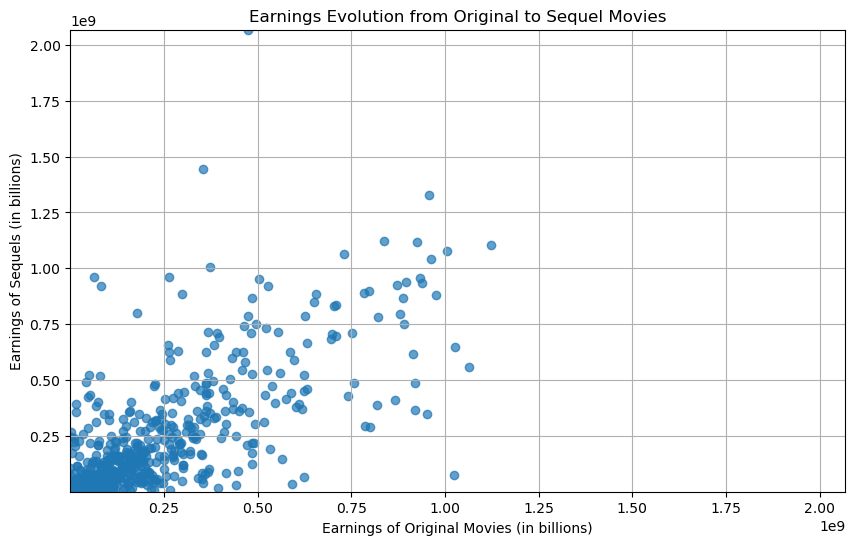

In [140]:
# Extract the 'Original' and 'Sequel' earnings columns from the DataFrame
x = earnings['Original']
y = earnings['Sequel']

# Create a scatter plot to visualize the earnings evolution from original to sequel movies
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7)

# Set labels and title for the plot
plt.xlabel('Earnings of Original Movies (in billions)')
plt.ylabel('Earnings of Sequels (in billions)')
plt.title('Earnings Evolution from Original to Sequel Movies')

# Add a grid to the plot
plt.grid(True)

# Determine the common limits for the axes based on the maximum and minimum earnings values
max_limit = max(earnings['Original'].max(), earnings['Sequel'].max())
min_limit = min(earnings['Original'].min(), earnings['Sequel'].min())

# Set the same scale for both axes to ensure consistent visualization
plt.xlim(min_limit, max_limit)
plt.ylim(min_limit, max_limit)

# Display the plot
plt.show()

The scatter plot reveals a positive correlation between the earnings of original movies and their sequels, indicating that sequels often emulate the financial performance of their predecessors. Let's use linear regression to try to fit a line in our plot.

In [141]:
# Define a linear regression model with 'Sequel' as the dependent variable and 'Original' as the independent variable
mod = smf.ols(formula='Sequel ~ Original', data=earnings)

# Fit the linear regression model
res = mod.fit()

# Print the summary statistics of the regression
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Sequel   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     880.8
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          3.19e-126
Time:                        20:17:46   Log-Likelihood:                -14392.
No. Observations:                 707   AIC:                         2.879e+04
Df Residuals:                     705   BIC:                         2.880e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.609e+07   8.34e+06      3.127      0.0

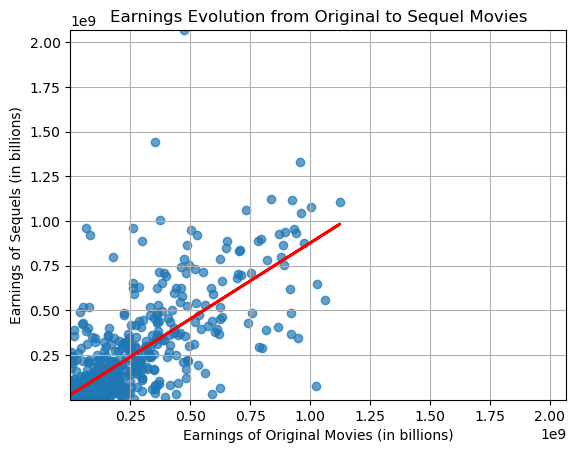

In [142]:
# Compute a linear fit
slope, intercept = np.polyfit(earnings['Original'], earnings['Sequel'], 1)
fit_line = slope * x + intercept

# Plot the original data
plt.scatter(x, y, alpha=0.7)

# Plot the fit line
plt.plot(x, fit_line, color='red', linewidth=2)

plt.xlabel('Earnings of Original Movies (in billions)')
plt.ylabel('Earnings of Sequels (in billions)')
plt.title('Earnings Evolution from Original to Sequel Movies')
plt.grid(True)

# Set the same scale for both axes
max_limit = max(x.max(), y.max())
min_limit = min(x.min(), y.min())
plt.xlim(min_limit, max_limit)
plt.ylim(min_limit, max_limit)

plt.show()

In [143]:
# Print the calculated slope
print(f'The slope is equal to {slope}.')

The slope is equal to 0.8513142817423899.


With an R-squared value of 0.555, the linear regression model seems to be a reasonable fit for the data.

Furthermore, the data exhibits a positive correlation, indicating that as earnings increase for original movies, there is a tendency for earnings to increase for their sequels as well. Most of the data points cluster in the lower left quadrant, suggesting that the majority of movie pairs earn less than 0.5 billion dollars. However, as earnings rise, there is some dispersion of points.

Notably, there are several outliers where sequels have significantly outperformed the earnings of the original movies, positioning themselves well above the line of equality. These instances highlight the potential for sequels to achieve remarkable box office success, occasionally surpassing the earnings of the original films. Let's delve into the top 3 highest-earning sequels to explore this further.

In [144]:
# Select the top three earning sequels
top_three_earning_sequels = earnings.nlargest(3, 'Sequel')

# Display the names and earnings of the top three sequels
print(top_three_earning_sequels[['SequelMovieName', 'Sequel']])

                                    SequelMovieName        Sequel
742        Star Wars Episode VII: The Force Awakens  2.068224e+09
2544                              Top Gun: Maverick  1.443725e+09
2803  Harry Potter and the Deathly Hallows – Part 2  1.328111e+09


Star Wars, Top Gun and Harry Potter, we are not surprised to see those movie names. With Christmas around the corner, let's take a look at the financial success of the Harry Potter saga.

Since we expected to encounter sagas during our analysis of sequels, we made the choice to include all movies that came after the first one both as originals and as sequels. In other words, the first Harry Potter movie will only be in the originals dataframe, the last Harry Potter movie will only be in the sequels dataframe, and the other ones will be in both dataframes. 

In [146]:
# We start by locating the first Harry Potter movie, which is present in the 'df_originals' dataset.
# To distinguish it from other Harry Potter movies, we use the title 'Philosopher's Stone'.
harry_potter_1 = df_originals[df_originals['MovieName'].str.contains("Philosopher's Stone", case=False, na=False)]

# Next, we identify all the Harry Potter sequels by searching for movie names containing 'Harry Potter'.
harry_potter_sequels = df_sequels[df_sequels['MovieName'].str.contains("Harry Potter", case=False, na=False)]

# We combine the first movie and its sequels into a single DataFrame.
harry_potter_saga = pd.concat([harry_potter_1, harry_potter_sequels], axis=0)

# Display the relevant information for the Harry Potter saga.
print(harry_potter_saga[['MovieName', 'ReleaseDate', 'BoxOffice']])

                                           MovieName ReleaseDate     BoxOffice
71442       Harry Potter and the Philosopher's Stone  2001-11-16  9.747554e+08
59574   Harry Potter and the Deathly Hallows: Part I  2010-11-17  9.563997e+08
17924      Harry Potter and the Order of the Phoenix  2007-06-28  9.398859e+08
7358          Harry Potter and the Half-Blood Prince  2009-07-06  9.344165e+08
41251       Harry Potter and the Prisoner of Azkaban  2004-06-04  7.966885e+08
10820            Harry Potter and the Goblet of Fire  2005-11-06  8.969111e+08
30278  Harry Potter and the Deathly Hallows – Part 2  2011-07-07  1.328111e+09
41200        Harry Potter and the Chamber of Secrets  2002-11-03  8.789796e+08


Let's plot the earnings from the saga as they keep coming out with new movies.

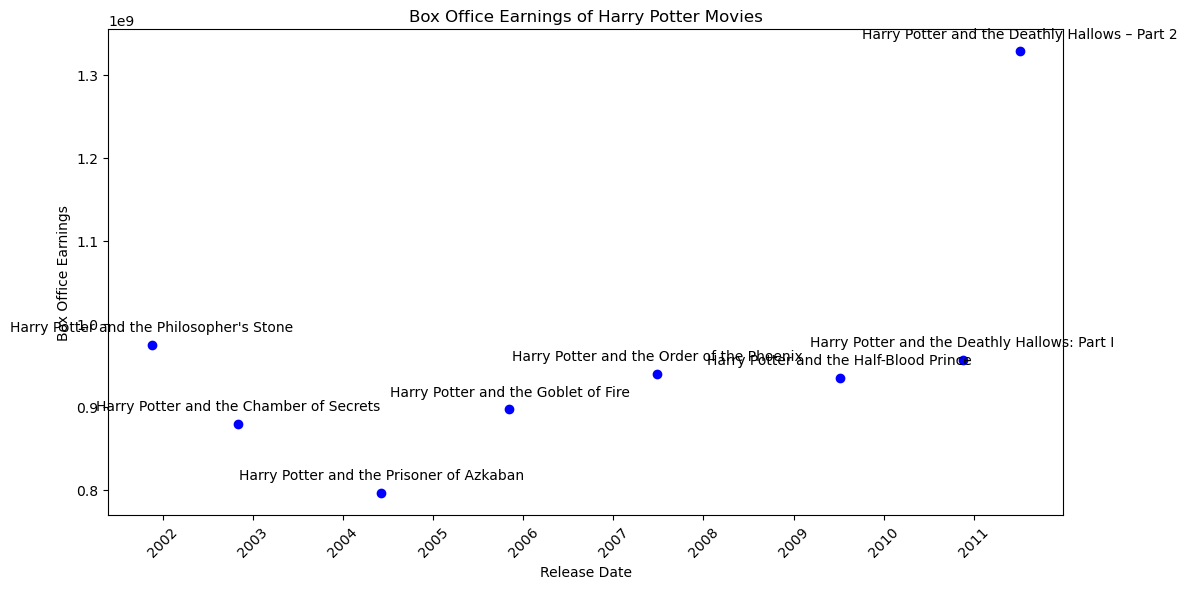

In [147]:
# Convert 'ReleaseDate' column to datetime format
harry_potter_saga['ReleaseDate'] = pd.to_datetime(harry_potter_saga['ReleaseDate'])

# Sort the DataFrame by 'ReleaseDate' in ascending order
harry_potter_df_sorted = harry_potter_saga.sort_values(by='ReleaseDate', ascending=True)

# Create a scatter plot to visualize box office earnings over time
plt.figure(figsize=(12, 6))

# Plot the points (release date vs. box office earnings) in blue
plt.scatter(harry_potter_df_sorted['ReleaseDate'], harry_potter_df_sorted['BoxOffice'], color='blue')

# Annotate each point with the movie name to provide context
for i, row in harry_potter_df_sorted.iterrows():
    plt.annotate(row['MovieName'], (row['ReleaseDate'], row['BoxOffice']), textcoords="offset points", xytext=(0,10), ha='center')

# Set labels and title for the plot
plt.xlabel('Release Date')
plt.ylabel('Box Office Earnings')
plt.title('Box Office Earnings of Harry Potter Movies')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust the layout to ensure all labels are visible
plt.tight_layout()

# Display the plot
plt.show()

The final Harry Potter movie made, by far, the most earnings. This is not surprising, as we would expect the final movie of this very successful saga to gather a lot of attention. However, it is interesting to see that Harry Potter and the Prisoner of Azkaban, which is the third movie, made the least earnings. This result came off as a bit odd. One possible theory is that Harry Potter lovers could notice that the story took a bit of a darker turn in this third release, with a more serious tone and visuals getting notably more scary. This may have had an impact on the audience, and, consequently, on the earnings.

Conversely, the plot also indicates instances where sequels underperformed despite their originals' high earnings. A notable example is an original-sequel pair where the sequel, earning 0.25 billion, had relatively disappointing financial returns compared to its original, which garnered over one billion at the box office.

In [148]:
# Select sequels that meet the criteria of having an original movie earning over 1 billion and a sequel earning less than 250 million
one_disappointing_sequel = earnings[(earnings['Original'] > 1000000000.0) & (earnings['Sequel'] < 250000000.0)]

# Print the names of the these sequels
print(one_disappointing_sequel['SequelMovieName'])

472    Alice Through the Looking Glass
Name: SequelMovieName, dtype: object


This is the sequel to 'Alice in Wonderland,' which was released in 2016. According to Wikipedia, the movie was praised for its visuals, but the critics were not impressed with the storyline.

After focusing on original-sequel pairs, let's see the distribution of earnings for originals and sequels as a whole.

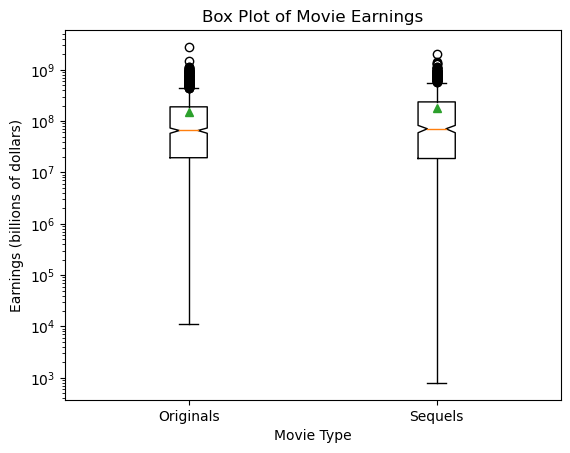

In [149]:
# Combine the earnings data into a list for box plot creation
original_earnings = df_originals.dropna(subset=['BoxOffice'])
sequels_earnings= df_sequels.dropna(subset=['BoxOffice'])
earnings_data = [original_earnings['BoxOffice'], sequels_earnings['BoxOffice']]

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Create the boxplot
bp = plt.boxplot(earnings_data, labels=['Originals', 'Sequels'], notch=True, showmeans=True)

# Set labels for the axes and a title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Earnings (billions of dollars)')
plt.title('Box Plot of Movie Earnings')

# Show the plot
plt.show()

It is difficult to see if originals rake in more money than sequels. Let's explore the values.

In [151]:
# Calculate summary statistics of original movie earnings
original_earnings.describe()

,WikipediaID,BoxOffice,Runtime
count,1.191000e+03,1.191000e+03,1179.000000
mean,6.098525e+06,1.495023e+08,104.302375
std,9.201339e+06,2.183721e+08,22.020681
min,3.217000e+03,1.138500e+04,48.000000
25%,5.179955e+05,1.934209e+07,90.000000
50%,1.688077e+06,6.557289e+07,99.000000
75%,6.147536e+06,1.895049e+08,114.000000
max,3.613202e+07,2.782275e+09,366.000000


In [153]:
# Calculate summary statistics of sequels earnings
sequels_earnings.describe()

,WikipediaID,BoxOffice,Runtime
count,7.760000e+02,8.720000e+02,859.000000
mean,6.985903e+06,1.801572e+08,104.967986
std,9.850598e+06,2.533134e+08,21.109338
min,3.217000e+03,7.956610e+02,64.000000
25%,6.858785e+05,1.866308e+07,90.000000
50%,2.066218e+06,7.085204e+07,100.000000
75%,7.863242e+06,2.363507e+08,116.000000
max,3.674573e+07,2.068224e+09,269.000000


It seems that sequels rank more money than originals. But the datasets have missing values.

In [154]:
# Calculate the percentage of original movies that have revenue information in the dataset
print(f'Percentage of originals that have revenue in the dataset: {len(original_earnings) / len(df_has_sequels):.2f}')

# Calculate the percentage of movies with no sequels that have revenue information in the dataset
print(f'Percentage of movies with no sequels that have revenue in the dataset: {len(sequels_earnings) / len(df_sequels):.2f}')

Percentage of originals that have revenue in the dataset: 0.31
Percentage of movies with no sequels that have revenue in the dataset: 0.23


Only 31% and 23% of the data repespectively is present. We need a deeper analysis to see if originals tend to generate more money than sequels.

In [ ]:
# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(original_earnings['BoxOffice'], sequels_earnings['BoxOffice'], equal_var=False)

# Print the results
print(f'T-test Statistic: {t_stat}')
print(f'P-value: {p_value}')

# Define the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in earnings between original movies and their sequels.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in earnings between original movies and their sequels.')


T-test Statistic: -2.8758159741407163
P-value: 0.004079850030368964
Reject the null hypothesis: There is a significant difference in earnings between original movies and their sequels.


### Duration 

Now we focus on the evolution of the duration between originals and sequels. As for the earnings, we create pairs of original-sequel movies, and we take into account the outliers noticed in Part 1 and filter the movies.

In [155]:
# Create a DataFrame for movie durations
duration = pd.DataFrame()

# Add columns for original movie data
duration['OriginalWikidataID'] = df_originals['WikidataID'].reset_index(drop=True)
duration['OriginalMovieName'] = df_originals['MovieName'].reset_index(drop=True)
duration['Original'] = df_originals['Runtime'].reset_index(drop=True)

# Add columns for sequel movie data
duration['SequelWikidataID'] = df_sequels['WikidataID'].reset_index(drop=True)
duration['SequelMovieName'] = df_sequels['MovieName'].reset_index(drop=True)
duration['Sequel'] = df_sequels['Runtime'].reset_index(drop=True)

# Remove rows with missing data in either original or sequel columns
duration = duration.dropna(subset=['Original', 'Sequel'])

# Filter the duration data for original movies within the range of 40 to 300 minutes
filtered_duration = duration[(duration['Original'] >= 40) & (duration['Original'] < 300)]

# Filter the duration data for sequels within the range of 40 to 300 minutes
filtered_duration = filtered_duration[(filtered_duration['Sequel'] >= 40) & (filtered_duration['Sequel'] < 300)]

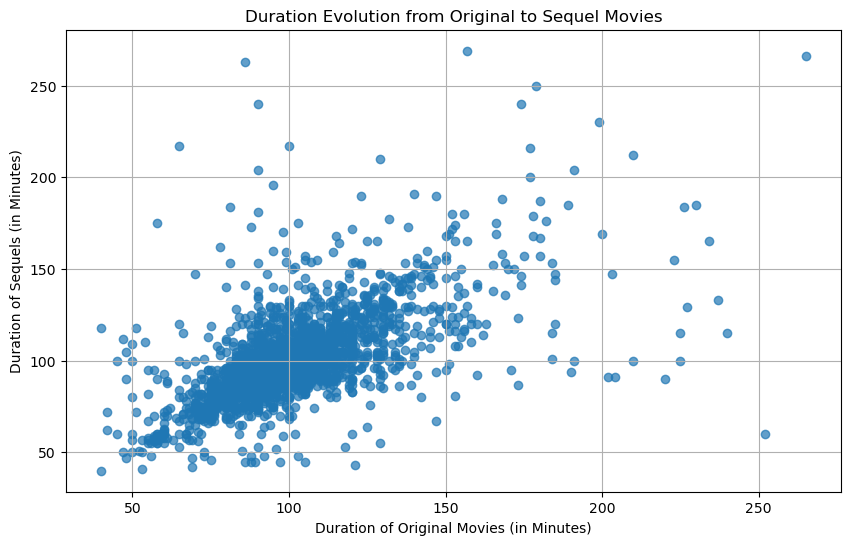

In [156]:
# Create a scatter plot to visualize the evolution of movie duration from original to sequel
plt.figure(figsize=(10, 6))
plt.scatter(filtered_duration['Original'], filtered_duration['Sequel'], alpha=0.7)

# Label the axes and set the plot title
plt.xlabel('Duration of Original Movies (in Minutes)')
plt.ylabel('Duration of Sequels (in Minutes)')
plt.title('Duration Evolution from Original to Sequel Movies')
plt.grid(True)

# Display the plot
plt.show()

There seems to be a strong positive correlation, suggesting that a linear fit would be suitable. This implies that sequels typically have a runtime similar to their original movies, a trend consistent with expectations. A significant deviation in runtime might indicate a change in the film's nature, which is uncommon for sequels.

In [159]:
# Perform linear regression analysis to assess the relationship between original and sequel movie durations
mod = smf.ols(formula='Sequel ~ Original', data=filtered_duration)
res = mod.fit()

# Print the summary of the regression analysis
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Sequel   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     1729.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          4.67e-293
Time:                        20:27:00   Log-Likelihood:                -11678.
No. Observations:                2724   AIC:                         2.336e+04
Df Residuals:                    2722   BIC:                         2.337e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.4165      1.526     24.512      0.0

Despite an R squared value of only 0.389, confirming the adequacy of a linear regression to explain the underlying link remains inconclusive.

An intriguing outlier involves an original-sequel pair where the original movie runs for over four hours, whereas the sequel is approximately one hour long. Let's see what happened there.

In [160]:
# Find sequels with significantly shorter durations compared to their original movies
one_short_sequel = filtered_duration[(filtered_duration['Original'] > 250) & (filtered_duration['Sequel'] < 70)]

# Print the names of sequels that meet the criteria
print(one_short_sequel['SequelMovieName'])

2729    Superman and the Mole Men
Name: SequelMovieName, dtype: object


Apparently (precisely, on [Wikipedia](https://en.wikipedia.org/wiki/Superman_and_the_Mole_Men)), this 1951 Superman feature, with a runtime of only 58 minutes, initially functioned as a preliminary release for the syndicated 'Adventures of Superman' TV series. It eventually became the series' sole two-part episode, known as "The Unknown People".

### Year of Release

An interesting question is to see how later down the road do these sequels typically appear. Let's investigate.

In [161]:
# Function to extract the year from a date string
# If the date string is invalid, it returns None
def extract_year(date_str):
    try:
        return pd.to_datetime(date_str, errors='coerce').year
    except ValueError:
        return None

In [162]:
# Create a DataFrame to store release year information
release = pd.DataFrame()

# Add columns for original movie's WikidataID, MovieName, and Release Year
release['OriginalWikidataID'] = df_originals['WikidataID'].reset_index(drop=True)
release['OriginalMovieName'] = df_originals['MovieName'].reset_index(drop=True)
release['Original'] = df_originals['ReleaseDate'].apply(extract_year).reset_index(drop=True)

# Add columns for sequel movie's WikidataID, MovieName, and Release Year
release['SequelWikidataID'] = df_sequels['WikidataID'].reset_index(drop=True)
release['SequelMovieName'] = df_sequels['MovieName'].reset_index(drop=True)
release['Sequel'] = df_sequels['ReleaseDate'].apply(extract_year).reset_index(drop=True)

# Drop rows with missing values in Original and Sequel release years
release = release.dropna(subset=['Original', 'Sequel'])

# Calculate the year difference between Sequel and Original releases
release['YearDifference'] = release['Sequel'] - release['Original']

# Keep rows where the YearDifference is greater than or equal to 0
release = release[release['YearDifference'] >= 0]

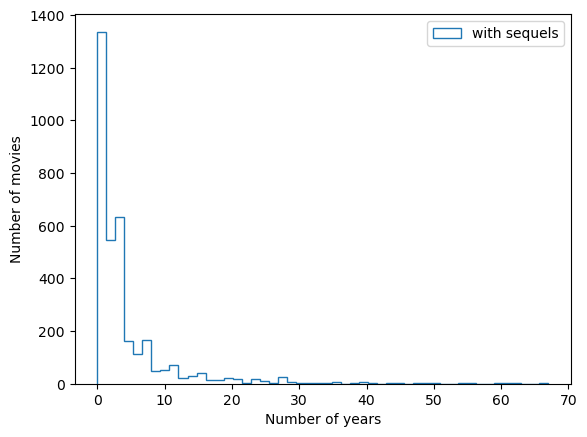

In [163]:
# Define the number of bins for the histogram
n_bins = 50

# Create a histogram of the year difference between sequels and originals
plt.hist(release['Sequel'] - release['Original'], bins=n_bins, histtype="step", label='with sequels')

# Set the labels for the x and y axes
plt.xlabel('Number of years')
plt.ylabel('Number of movies')

# Add a legend to the plot
plt.legend(loc='best')

# Display the histogram
plt.show()

In [164]:
# Calculate summary statistics of the year difference between original movies and their sequels
release['YearDifference'].describe()

count    3400.000000
mean        4.321176
std         6.579571
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        67.000000
Name: YearDifference, dtype: float64

We can see that the average gap for the release time gap between original movies and their sequels is about 4.32 years, with a substantial standard deviation of 6.57 years, indicating some variation. The median of 2 years suggests that most sequels are released within a relatively short timeframe after their originals. However, the maximum gap of 67 years points most-likely to some notable exceptions, possibly involving reboots or long-delayed continuations. 

Let's see which sequel appeared 67 years after the original movie.

In [ ]:
# Find the row with the maximum gap
max_gap_info = release[release['YearDifference'] == release['YearDifference'].max()]
max_gap_info

,OriginalWikidataID,OriginalMovieName,Original,SequelWikidataID,SequelMovieName,Sequel,YearDifference
2907,Q1402027,La canción del milagro,1940.0,Q1286531,"No Fits, No Fights, No Feuds",2007.0,67.0


["No Fits, No Fights, No Feuds"](https://en.wikipedia.org/wiki/No_Fits,_No_Fights,_No_Feuds) is an episode from the TV series "Desperate Housewives." It aired on January 7, 2007, and is part of the show's third season. On the other hand, ["La canción del milagro"](https://en.wikipedia.org/wiki/The_Miracle_Song) (The Miracle Song) is a Mexican film released in 1940. It is a musical drama noted for its contributions to the Mexican cinema of the 1940s and is presented in Spanish. 

This seems to be a data scraping error, as a TV series episode has mistakenly made its way into our movie dataset. But, on a lighter note, maybe TV shows should consider rebooting old movies as special episodes, say, around 67 years later!

### Character exploration

The challenge lies in the fact  that we have information about the characters only for movies in the `cmu_movies` dataset, and not for the movies that we managed to scrape. Therefore, our objective is to select pairs of originals and sequels where both movies can be found in the `cmu_movies` dataset.

In [165]:
# Get the sequels that are in cmu_movies
sequels_in_cmu = cmu_movies_merged[cmu_movies_merged['WikidataID'].isin(df_sequels['WikidataID'])]

# Drop the duplicates
sequels_in_cmu = sequels_in_cmu.drop_duplicates(subset=['WikidataID', 'PrequelID'])

# Reset the index
sequels_in_cmu = sequels_in_cmu.reset_index(drop=True)

# Display the DataFrame
display(sequels_in_cmu)

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres,WikidataID,PrequelID,SequelID
0,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974,NaN,89.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",Q840296,Q1754737,NaN
1,2647998,/m/07v6f3,The Human Tornado,1976,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hj3l_y...",Q2534503,Q1764969,NaN
2,33059372,/m/0h54gth,ChromeSkull: Laid to Rest 2,2011-09-20,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03npn"": ""Horror"", ""/m/01585b"": ""Slasher""}",Q5113757,Q9020056,NaN
3,33495214,/m/0h95z9x,Zum Teufel mit der Penne,1968-12-12,NaN,99.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/05p553"": ""Comedy film""}",Q229557,Q230294,Q1354125
4,2509881,/m/07jwzw,Critters 3,1991,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""H...",Q1140559,Q739849,Q771537
...,...,...,...,...,...,...,...,...,...,...,...,...
2598,28149275,/m/0cmdskt,How Poets Are Enjoying Their Lives,1988-06,NaN,102.0,"{""/m/01wgr"": ""Czech Language""}","{""/m/01mk6"": ""Czechoslovakia""}","{""/m/01z4y"": ""Comedy""}",Q5918080,Q5918075,Q6429064
2599,454812,/m/02bjfb,Night of Dark Shadows,1971-08-03,NaN,129.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",Q3341403,Q3208837,NaN
2600,11350779,/m/02r8kxp,Sherlock Holmes and the Voice of Terror,1942-09-18,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",Q1216506,Q1210852,Q255314
2601,28373912,/m/052nnlv,Jan Zizka,1956-02-05,NaN,105.0,"{""/m/01wgr"": ""Czech Language""}","{""/m/01mk6"": ""Czechoslovakia""}","{""/m/07s9rl0"": ""Drama"", ""/m/082gq"": ""War film""}",Q6150472,Q3467727,Q12294915


In [166]:
# Create the dataset containing the corresponding originals
originals_in_cmu = pd.DataFrame()

# Iterate through sequels_in_cmu to find corresponding originals
for index, row in sequels_in_cmu.iterrows():
    sequelID = row['WikidataID']
    original_row = cmu_movies_merged.loc[cmu_movies_merged['SequelID'] == sequelID]

    # If there's exactly one matching original, add it to the DataFrame
    if len(original_row) == 1:
        originals_in_cmu = pd.concat([original_row, originals_in_cmu])

    # If there are multiple matching originals, add the first one
    else:
        originals_in_cmu = pd.concat([original_row.iloc[0:1], originals_in_cmu])

# Reset the index of the resulting DataFrame
originals_in_cmu = originals_in_cmu.iloc[::-1].reset_index(drop=True)

# Display the DataFrame
display(originals_in_cmu)

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres,WikidataID,PrequelID,SequelID
0,9442685,/m/028908s,Lady Snowblood,1973,NaN,97.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",Q1754737,NaN,Q840296
1,1341543,/m/04v3j2,Dolemite,1974,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0219x_""...",Q1764969,NaN,Q2534503
2,18664228,/m/04gt4sx,Laid to Rest,2009,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03npn"": ""Horror"", ""/m/01585b"": ""Slasher""}",Q9020056,NaN,Q5113757
3,34064420,/m/0hrhvxq,Zur Hölle mit den Paukern,1968-04-04,NaN,85.0,"{""/m/04306rv"": ""German Language""}","{""/m/082fr"": ""West Germany""}","{""/m/05p553"": ""Comedy film""}",Q230294,NaN,Q229557
4,2509859,/m/02p6k7l,Critters 2: The Main Course,1988,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""H...",Q739849,Q1140566,Q1140559
...,...,...,...,...,...,...,...,...,...,...,...,...
2598,23509192,/m/06w6yz4,How Poets Are Losing Their Illusions,1985-04-01,NaN,98.0,"{""/m/01wgr"": ""Czech Language""}","{""/m/01mk6"": ""Czechoslovakia""}","{""/m/05p553"": ""Comedy film""}",Q5918075,Q5918429,Q5918080
2599,2396634,/m/0795h0,House of Dark Shadows,1970,NaN,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/02l7c8"": ""Romance ...",Q3208837,NaN,Q3341403
2600,6435145,/m/0g57sd,The Adventures of Sherlock Holmes,1939,NaN,81.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/028v3"": ""Detecti...",Q1210852,Q1194465,Q1216506
2601,28373887,/m/052nnld,Jan Hus,1954,NaN,115.0,{},"{""/m/01mk6"": ""Czechoslovakia""}","{""/m/07s9rl0"": ""Drama""}",Q3467727,NaN,Q6150472


Let's begin by analyzing the evolution in the number of characters between an original movie and its sequel. 

In [167]:
# Merge the characters infos with the movies features for both originals and sequels
originals_with_characters = pd.merge(originals_in_cmu, all_characters_df, how='left', left_on='WikipediaID', right_on='WikipediaID')
sequels_with_characters = pd.merge(sequels_in_cmu, all_characters_df, how='left', left_on='WikipediaID', right_on='WikipediaID')

# Extract movie IDs for originals and sequels
originals_ids = set(originals_with_characters['WikipediaID'])
sequels_ids = set(sequels_with_characters['WikipediaID'])

# Filter characters based on whether their movie ID is in the originals or sequels list
originals_characters = originals_with_characters[originals_with_characters['WikipediaID'].isin(originals_ids)]
sequels_characters = sequels_with_characters[sequels_with_characters['WikipediaID'].isin(sequels_ids)]

# Define the columns to be considered for analysis
columns = ['WikipediaID', 'ActorDOB', 'ActorGender', 'ActorAgeAtRelease', 'FreebaseActorID']

# Group the characters data by movie ID for both originals and sequels
grouped_originals_characters = originals_characters[columns].groupby('WikipediaID')
grouped_sequels_characters = sequels_characters[columns].groupby('WikipediaID')

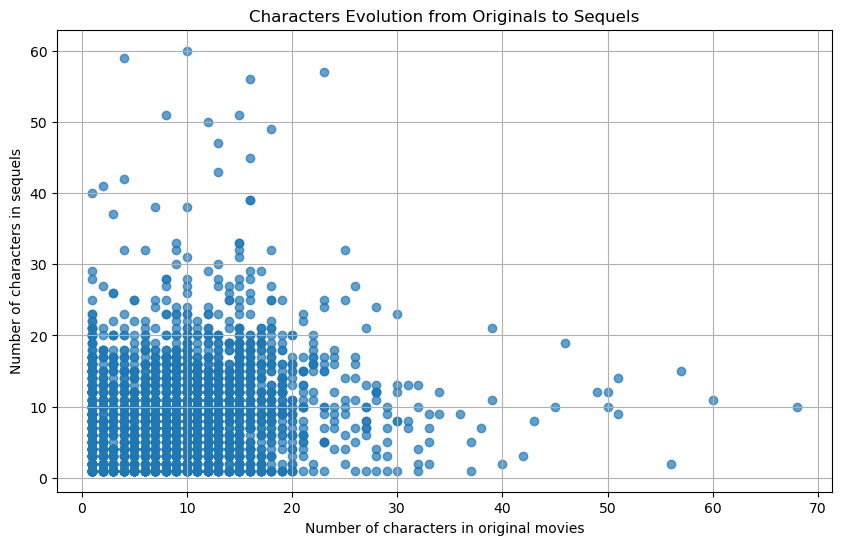

In [168]:
# Calculate the number of characters in original movies and sequels
originals_nb_characters = grouped_originals_characters.size()
sequels_nb_characters = grouped_sequels_characters.size()

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(originals_nb_characters, sequels_nb_characters, alpha=0.7)

plt.xlabel('Number of characters in original movies')
plt.ylabel('Number of characters in sequels')
plt.title('Characters Evolution from Originals to Sequels')
plt.grid(True)

plt.show()

We can see that the majority of the data points cluster within the lower quadrant, suggesting that films generally maintain a character count below 20. Notably, there are several outliers where the number of characters in sequels shows a marked increase or decrease compared to the originals. 

While some of these points might indicate a significant narrative expansion or reduction, these outliers are likely not reflective of actual changes in the movies' character counts but could instead be the result of data collection errors. Discrepancies in the dataset, possibly arising from the data scraping methodology, account for most of these anomalies. This compromises the dataset's reliability, thereby limiting the precision of our analysis regarding character evolution in movie sequels.

To further explore the characters' evolution, we will analyze the differences in gender and age of actors between original movies and their sequels, as this information is available.

#### Actors gender

In this section, we will analyze the gender distribution of actors in movies, particularly focusing on original movies and their corresponding sequels. We will examine how the gender composition of actors evolves from the original movies to their sequels, providing insights into gender representation in the film industry.

In [169]:
# Calculate the count of female actors in original movies and sequels
originals_female_counts = grouped_originals_characters.apply(lambda x: (x['ActorGender'] == 'F').sum())
sequels_female_counts = grouped_sequels_characters.apply(lambda x: (x['ActorGender'] == 'F').sum())

# Calculate the percentage of female actors in original movies and sequels
originals_female_percentage = originals_female_counts / originals_nb_characters * 100
originals_female_percentage = originals_female_percentage.reset_index(drop=True)

sequels_female_percentage = sequels_female_counts / sequels_nb_characters * 100
sequels_female_percentage = sequels_female_percentage.reset_index(drop=True)

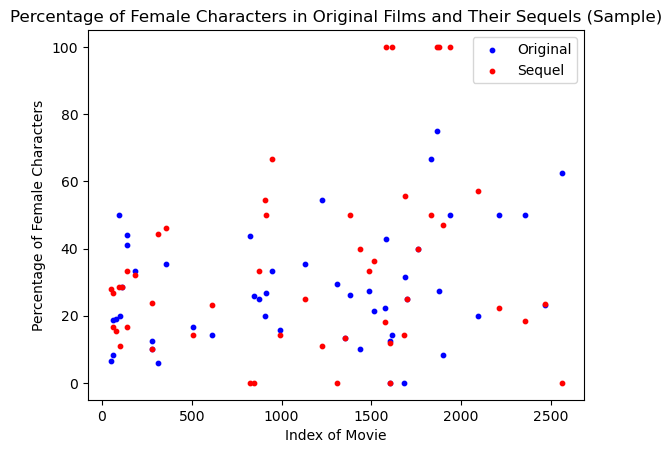

In [170]:
# Set the sample size
sample_size = 50

# Generate random indices for sampling
random_indices = np.random.choice(originals_female_percentage.size, size=sample_size, replace=False)

# Take a sample of 50 from each dataset using the generated indices
originals_sample = originals_female_percentage[random_indices]
sequels_sample = sequels_female_percentage[random_indices]

# Create a scatter plot without error bars using the samples
plt.scatter(random_indices, originals_sample, s=10, color='blue', label='Original')
plt.scatter(random_indices, sequels_sample, s=10, color='red', label='Sequel')

# Adding titles and labels
plt.title('Percentage of Female Characters in Original Films and Their Sequels (Sample)')
plt.xlabel('Index of Movie')
plt.ylabel('Percentage of Female Characters')

# Display the legend
plt.legend()

# Show the plot
plt.show()

#### Actors age

We will explore the differences in the average ages of the actors. To do so, we will compare the average age in originals and the adjusted average age in sequels, where the adjustment involves subtracting the year difference between the release years of the two movies. There are NaN values in the 'ActorAgeAtRelease' column, so we decided to replace them by the mean age.

In [171]:
# Extract the release years of original movies and sequels
originals_release_year = originals_in_cmu['ReleaseDate'].apply(extract_year)
sequels_release_year = sequels_in_cmu['ReleaseDate'].apply(extract_year)

# Calculate the difference in years between sequels and their corresponding original movies
year_difference_org_seq = sequels_release_year - originals_release_year

In [173]:
# Compute the mean ages and add them to the grouped data
originals_mean_age = grouped_originals_characters['ActorAgeAtRelease'].mean().reset_index(drop=True)
sequels_mean_age = grouped_sequels_characters['ActorAgeAtRelease'].mean().reset_index(drop=True)

# Calculate the difference in average age between the original and sequel movies
age_difference = sequels_mean_age - originals_mean_age

In [174]:
# Sort the year differences in ascending order
year_difference_org_seq = year_difference_org_seq.sort_values()

# Sort the age differences in ascending order
age_difference = age_difference.sort_values()

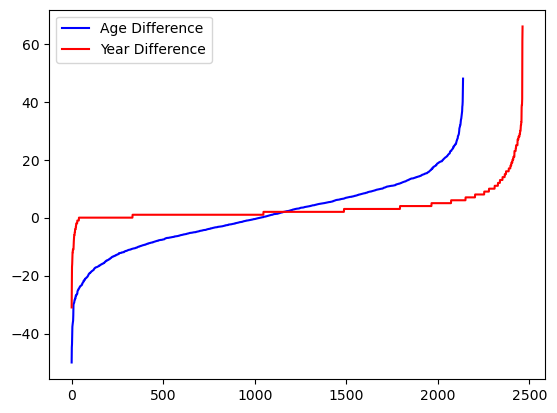

In [175]:
# Create an array 'x' for the x-axis, ranging from 0 to the length of 'age_difference'
x = np.arange(len(age_difference))

# Plot 'age_difference' in blue
plt.plot(x, age_difference, 'b-', label='Age Difference')

# Create another array 'x' for the x-axis, ranging from 0 to the length of 'year_difference_org_seq'
x = np.arange(len(year_difference_org_seq))

# Plot 'year_difference_org_seq' in red
plt.plot(x, year_difference_org_seq, 'r-', label='Year Difference')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()